In [1]:
!nvidia-smi

Sat Feb 24 12:06:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   33C    P8              22W / 215W |    820MiB /  8192MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
sr = 16000
data_dir = '../data/data_preprocessed/iemocap/preprocessing/'
data_x = np.load(f'{data_dir}iemocap.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}iemocap.label4.npy', allow_pickle=True)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3948
Test: 988


In [13]:
y_train[0]

'ang'

In [14]:
np.unique(y_train)

array(['ang', 'hap', 'neu', 'sad'], dtype=object)

In [15]:
labels = ['ang', 'neu', 'sad', 'hap']

In [16]:
def label_to_index(word):
    return labels.index(word)
label_to_index(y_train[0])

0

In [17]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [18]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [19]:
import traceback

In [20]:
from IConNet.nn.model import M18
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m18.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M18(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 2, 'n_channel': [129, 30], 'kernel_size': [127, 63], 'stride': [2, 8], 'window_k': [9, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 32, 'out_seq_length': 8, 'use_context': True, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.1}}


M18(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(160, 32, batch_first=True)
    (pad_layer)

In [21]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [22]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [23]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                              | 0.006514657980456026/10 [00:00<17:50, 107.15s/it]

Train Epoch: 1 [0/3948 (0%)]	Loss: 1.488819
Mem before-during-after: 3256832 2642309120 37331968


  1%|▍                               | 0.13355048859934857/10 [00:11<15:36, 94.95s/it]

Train Epoch: 1 [640/3948 (16%)]	Loss: 1.351187
Mem before-during-after: 37331968 2661083648 37331968


  3%|▊                                | 0.2638436482084691/10 [00:23<15:40, 96.57s/it]

Train Epoch: 1 [1280/3948 (33%)]	Loss: 1.165046
Mem before-during-after: 37331968 2661083648 37331968


  4%|█▎                               | 0.3973941368078177/10 [00:35<15:29, 96.78s/it]

Train Epoch: 1 [1920/3948 (49%)]	Loss: 1.326882
Mem before-during-after: 37331968 2661083648 37331968


  5%|█▋                               | 0.5276872964169382/10 [00:46<13:25, 85.03s/it]

Train Epoch: 1 [2560/3948 (65%)]	Loss: 1.073302
Mem before-during-after: 37331968 2661083648 37331968


  7%|██▏                              | 0.6579804560260588/10 [00:57<12:59, 83.41s/it]

Train Epoch: 1 [3200/3948 (81%)]	Loss: 1.128887
Mem before-during-after: 37331968 2661083648 37331968


  8%|██▌                              | 0.7850162866449514/10 [01:08<14:18, 93.12s/it]

Train Epoch: 1 [3840/3948 (98%)]	Loss: 1.193016
Mem before-during-after: 37331968 2661083648 37331968


 10%|███▎                             | 1.0000000000000002/10 [01:21<08:12, 54.75s/it]


Test Epoch: 1	Accuracy: 428/976 (43%)



 10%|███▎                             | 1.0065146579804563/10 [01:21<09:20, 62.36s/it]

Train Epoch: 2 [0/3948 (0%)]	Loss: 1.069245
Mem before-during-after: 37327872 2661077504 37220352


 11%|███▋                             | 1.1335504885993488/10 [01:33<14:22, 97.24s/it]

Train Epoch: 2 [640/3948 (16%)]	Loss: 1.320167
Mem before-during-after: 37220352 2661809152 38124544


 13%|████▏                            | 1.2671009771986974/10 [01:44<12:25, 85.41s/it]

Train Epoch: 2 [1280/3948 (33%)]	Loss: 0.999371
Mem before-during-after: 38124544 2662510080 37220352


 14%|████▊                             | 1.397394136807818/10 [01:56<12:24, 86.54s/it]

Train Epoch: 2 [1920/3948 (49%)]	Loss: 1.017015
Mem before-during-after: 37220352 2661809152 37220352


 15%|█████                            | 1.5244299674267106/10 [02:07<13:15, 93.84s/it]

Train Epoch: 2 [2560/3948 (65%)]	Loss: 1.235688
Mem before-during-after: 37220352 2660142080 37220352


 17%|█████▍                           | 1.6579804560260591/10 [02:18<11:29, 82.68s/it]

Train Epoch: 2 [3200/3948 (81%)]	Loss: 1.027238
Mem before-during-after: 38124544 2660572160 37220352


 18%|█████▉                           | 1.7850162866449517/10 [02:29<13:18, 97.20s/it]

Train Epoch: 2 [3840/3948 (98%)]	Loss: 1.065755
Mem before-during-after: 38124544 2660572160 37220352


 20%|██████▌                          | 2.0000000000000004/10 [02:41<07:11, 53.91s/it]


Test Epoch: 2	Accuracy: 447/976 (45%)



 20%|██████▌                          | 2.0032573289902285/10 [02:41<08:26, 63.32s/it]

Train Epoch: 3 [0/3948 (0%)]	Loss: 0.943393
Mem before-during-after: 37216256 2660140032 37220352


 21%|███████▎                          | 2.136807817589577/10 [02:52<10:44, 81.93s/it]

Train Epoch: 3 [640/3948 (16%)]	Loss: 0.815345
Mem before-during-after: 38124544 2661487616 38124544


 23%|███████▍                         | 2.2671009771986976/10 [03:04<10:46, 83.63s/it]

Train Epoch: 3 [1280/3948 (33%)]	Loss: 0.856265
Mem before-during-after: 38124544 2661487616 38124544


 24%|████████▏                         | 2.397394136807818/10 [03:15<10:28, 82.63s/it]

Train Epoch: 3 [1920/3948 (49%)]	Loss: 0.926419
Mem before-during-after: 38124544 2661487616 38124544


 25%|████████▎                        | 2.5244299674267108/10 [03:26<11:33, 92.79s/it]

Train Epoch: 3 [2560/3948 (65%)]	Loss: 1.176028
Mem before-during-after: 38124544 2661487616 38124544


 27%|████████▊                        | 2.6547231270358314/10 [03:37<11:37, 95.02s/it]

Train Epoch: 3 [3200/3948 (81%)]	Loss: 1.391590
Mem before-during-after: 38124544 2661487616 38124544


 28%|█████████▊                         | 2.78827361563518/10 [03:48<09:43, 80.96s/it]

Train Epoch: 3 [3840/3948 (98%)]	Loss: 1.128384
Mem before-during-after: 38124544 2661487616 38124544


 30%|██████████▏                       | 3.000000000000001/10 [04:00<06:17, 53.88s/it]


Test Epoch: 3	Accuracy: 426/976 (43%)



 30%|██████████▏                       | 3.006514657980457/10 [04:01<07:06, 61.05s/it]

Train Epoch: 4 [0/3948 (0%)]	Loss: 1.551882
Mem before-during-after: 37216256 2660140032 37220352


 31%|██████████▎                      | 3.1335504885993495/10 [04:11<10:31, 91.93s/it]

Train Epoch: 4 [640/3948 (16%)]	Loss: 1.308461
Mem before-during-after: 38124544 2661487616 38124544


 33%|███████████                       | 3.267100977198698/10 [04:23<09:18, 82.91s/it]

Train Epoch: 4 [1280/3948 (33%)]	Loss: 0.978675
Mem before-during-after: 38124544 2661487616 38124544


 34%|███████████▏                     | 3.3973941368078187/10 [04:33<08:57, 81.46s/it]

Train Epoch: 4 [1920/3948 (49%)]	Loss: 1.088413
Mem before-during-after: 38124544 2661487616 38124544


 35%|███████████▉                      | 3.524429967426711/10 [04:44<09:57, 92.30s/it]

Train Epoch: 4 [2560/3948 (65%)]	Loss: 1.034982
Mem before-during-after: 38124544 2661487616 38124544


 37%|████████████▊                      | 3.65798045602606/10 [04:55<08:34, 81.05s/it]

Train Epoch: 4 [3200/3948 (81%)]	Loss: 0.951661
Mem before-during-after: 38124544 2661487616 38124544


 38%|████████████                    | 3.7850162866449524/10 [05:06<10:39, 102.92s/it]

Train Epoch: 4 [3840/3948 (98%)]	Loss: 1.060753
Mem before-during-after: 38124544 2661046272 38124544


 40%|█████████████▌                    | 4.000000000000001/10 [05:18<05:26, 54.43s/it]


Test Epoch: 4	Accuracy: 403/976 (41%)



 40%|█████████████▌                    | 4.006514657980456/10 [05:19<06:00, 60.21s/it]

Train Epoch: 5 [0/3948 (0%)]	Loss: 1.189866
Mem before-during-after: 37216256 2660140032 37220352


 41%|██████████████                    | 4.136807817589559/10 [05:30<08:04, 82.70s/it]

Train Epoch: 5 [640/3948 (16%)]	Loss: 1.330279
Mem before-during-after: 38124544 2661487616 38124544


 43%|██████████████▌                   | 4.267100977198662/10 [05:41<07:41, 80.47s/it]

Train Epoch: 5 [1280/3948 (33%)]	Loss: 1.048594
Mem before-during-after: 38124544 2661487616 38124544


 44%|██████████████▌                  | 4.3973941368077645/10 [05:52<07:38, 81.84s/it]

Train Epoch: 5 [1920/3948 (49%)]	Loss: 1.042896
Mem before-during-after: 38124544 2661487616 38124544


 45%|███████████████▍                  | 4.527687296416867/10 [06:03<07:25, 81.37s/it]

Train Epoch: 5 [2560/3948 (65%)]	Loss: 0.922419
Mem before-during-after: 38124544 2661487616 38124544


 47%|████████████████▎                  | 4.65798045602597/10 [06:14<07:29, 84.06s/it]

Train Epoch: 5 [3200/3948 (81%)]	Loss: 1.012415
Mem before-during-after: 38124544 2661487616 38124544


 48%|████████████████▎                 | 4.788273615635073/10 [06:25<07:05, 81.66s/it]

Train Epoch: 5 [3840/3948 (98%)]	Loss: 1.203699
Mem before-during-after: 38124544 2661487616 38124544


 50%|████████████████▉                 | 4.999999999999865/10 [06:37<04:35, 55.10s/it]


Test Epoch: 5	Accuracy: 502/976 (51%)



 50%|█████████████████                 | 5.003257328990093/10 [06:37<05:20, 64.21s/it]

Train Epoch: 6 [0/3948 (0%)]	Loss: 1.204682
Mem before-during-after: 37216256 2660140032 37220352


 51%|█████████████████▍                | 5.136807817589423/10 [06:48<06:35, 81.26s/it]

Train Epoch: 6 [640/3948 (16%)]	Loss: 1.138710
Mem before-during-after: 38124544 2661487616 38124544


 53%|█████████████████▉                | 5.267100977198526/10 [06:59<06:32, 82.91s/it]

Train Epoch: 6 [1280/3948 (33%)]	Loss: 0.658737
Mem before-during-after: 38124544 2661487616 38124544


 54%|██████████████████▎               | 5.397394136807629/10 [07:10<06:20, 82.66s/it]

Train Epoch: 6 [1920/3948 (49%)]	Loss: 1.050263
Mem before-during-after: 38124544 2661487616 38124544


 55%|██████████████████▊               | 5.527687296416731/10 [07:21<06:06, 81.91s/it]

Train Epoch: 6 [2560/3948 (65%)]	Loss: 1.206877
Mem before-during-after: 38124544 2661487616 38124544


 57%|███████████████████▏              | 5.654723127035607/10 [07:32<06:42, 92.56s/it]

Train Epoch: 6 [3200/3948 (81%)]	Loss: 1.038911
Mem before-during-after: 38124544 2661487616 38124544


 58%|███████████████████              | 5.7850162866447095/10 [07:43<06:28, 92.27s/it]

Train Epoch: 6 [3840/3948 (98%)]	Loss: 1.161413
Mem before-during-after: 38124544 2661487616 38124544


 60%|████████████████████▍             | 5.999999999999729/10 [07:55<03:39, 54.78s/it]


Test Epoch: 6	Accuracy: 512/976 (52%)



 60%|████████████████████▍             | 6.006514657980184/10 [07:55<04:04, 61.27s/it]

Train Epoch: 7 [0/3948 (0%)]	Loss: 0.759637
Mem before-during-after: 37216256 2660140032 37220352


 61%|████████████████████▊             | 6.136807817589287/10 [08:06<05:15, 81.61s/it]

Train Epoch: 7 [640/3948 (16%)]	Loss: 1.035118
Mem before-during-after: 38124544 2661487616 38124544


 63%|█████████████████████▉             | 6.26710097719839/10 [08:17<05:06, 82.24s/it]

Train Epoch: 7 [1280/3948 (33%)]	Loss: 1.129676
Mem before-during-after: 38124544 2661487616 38124544


 64%|█████████████████████▊            | 6.397394136807493/10 [08:28<05:08, 85.51s/it]

Train Epoch: 7 [1920/3948 (49%)]	Loss: 0.830970
Mem before-during-after: 37220352 2660142080 37220352


 65%|██████████████████████▏           | 6.524429967426368/10 [08:39<05:21, 92.64s/it]

Train Epoch: 7 [2560/3948 (65%)]	Loss: 0.900204
Mem before-during-after: 37220352 2660142080 37220352


 67%|██████████████████████▋           | 6.657980456025698/10 [08:50<04:34, 82.00s/it]

Train Epoch: 7 [3200/3948 (81%)]	Loss: 1.197011
Mem before-during-after: 37220352 2660142080 37220352


 68%|███████████████████████           | 6.788273615634801/10 [09:01<04:23, 82.19s/it]

Train Epoch: 7 [3840/3948 (98%)]	Loss: 1.437533
Mem before-during-after: 37220352 2660142080 37220352


 70%|███████████████████████▊          | 6.999999999999593/10 [09:13<02:47, 55.95s/it]


Test Epoch: 7	Accuracy: 437/976 (44%)



 70%|███████████████████████▊          | 7.006514657980048/10 [09:14<03:04, 61.57s/it]

Train Epoch: 8 [0/3948 (0%)]	Loss: 1.226771
Mem before-during-after: 37216256 2660140032 37220352


 71%|████████████████████████▎         | 7.136807817589151/10 [09:25<03:55, 82.23s/it]

Train Epoch: 8 [640/3948 (16%)]	Loss: 0.913286
Mem before-during-after: 38124544 2661487616 38124544


 73%|████████████████████████▋         | 7.267100977198254/10 [09:36<03:44, 82.32s/it]

Train Epoch: 8 [1280/3948 (33%)]	Loss: 1.228654
Mem before-during-after: 38124544 2661487616 38124544


 74%|█████████████████████████▏        | 7.394136807817129/10 [09:46<04:00, 92.22s/it]

Train Epoch: 8 [1920/3948 (49%)]	Loss: 1.055585
Mem before-during-after: 38124544 2661487616 38124544


 75%|██████████████████████████▎        | 7.52768729641646/10 [09:57<03:24, 82.82s/it]

Train Epoch: 8 [2560/3948 (65%)]	Loss: 1.809697
Mem before-during-after: 38124544 2661487616 38124544


 77%|██████████████████████████        | 7.657980456025562/10 [10:08<03:11, 81.66s/it]

Train Epoch: 8 [3200/3948 (81%)]	Loss: 0.976355
Mem before-during-after: 38124544 2661487616 38124544


 78%|██████████████████████████▍       | 7.788273615634665/10 [10:19<03:06, 84.41s/it]

Train Epoch: 8 [3840/3948 (98%)]	Loss: 0.996305
Mem before-during-after: 38124544 2661487616 38124544


 80%|███████████████████████████▏      | 7.999999999999457/10 [10:31<01:50, 55.50s/it]


Test Epoch: 8	Accuracy: 507/976 (51%)



 80%|███████████████████████████▏      | 8.006514657979913/10 [10:32<02:06, 63.39s/it]

Train Epoch: 9 [0/3948 (0%)]	Loss: 0.879633
Mem before-during-after: 37216256 2660140032 37220352


 81%|███████████████████████████▋      | 8.136807817589052/10 [10:43<02:35, 83.34s/it]

Train Epoch: 9 [640/3948 (16%)]	Loss: 0.934007
Mem before-during-after: 38124544 2661487616 38124544


 83%|████████████████████████████▉      | 8.26710097719819/10 [10:54<02:21, 81.80s/it]

Train Epoch: 9 [1280/3948 (33%)]	Loss: 0.835600
Mem before-during-after: 38124544 2661487616 38124544


 84%|████████████████████████████▌     | 8.397394136807328/10 [11:05<02:13, 83.50s/it]

Train Epoch: 9 [1920/3948 (49%)]	Loss: 1.134585
Mem before-during-after: 38124544 2661487616 38124544


 85%|████████████████████████████▉     | 8.527687296416467/10 [11:16<02:00, 81.89s/it]

Train Epoch: 9 [2560/3948 (65%)]	Loss: 0.869940
Mem before-during-after: 38124544 2661487616 38124544


 87%|█████████████████████████████▍    | 8.654723127035377/10 [11:26<02:06, 93.80s/it]

Train Epoch: 9 [3200/3948 (81%)]	Loss: 1.596128
Mem before-during-after: 38124544 2661487616 38124544


 88%|█████████████████████████████▊    | 8.785016286644515/10 [11:37<01:52, 92.85s/it]

Train Epoch: 9 [3840/3948 (98%)]	Loss: 1.273308
Mem before-during-after: 38124544 2661487616 38124544


 90%|██████████████████████████████▌   | 8.999999999999593/10 [11:50<00:55, 55.23s/it]


Test Epoch: 9	Accuracy: 455/976 (46%)



 90%|███████████████████████████████▌   | 9.00651465798005/10 [11:50<01:01, 61.84s/it]

Train Epoch: 10 [0/3948 (0%)]	Loss: 1.322546
Mem before-during-after: 37216256 2660140032 37220352


 91%|███████████████████████████████   | 9.136807817589188/10 [12:01<01:10, 81.12s/it]

Train Epoch: 10 [640/3948 (16%)]	Loss: 0.817003
Mem before-during-after: 38124544 2661487616 38124544


 93%|███████████████████████████████▍  | 9.263843648208098/10 [12:12<01:08, 92.66s/it]

Train Epoch: 10 [1280/3948 (33%)]	Loss: 1.044118
Mem before-during-after: 38124544 2661046272 38124544


 94%|███████████████████████████████▉  | 9.397394136807465/10 [12:23<00:48, 81.22s/it]

Train Epoch: 10 [1920/3948 (49%)]	Loss: 0.971771
Mem before-during-after: 38124544 2661046272 38124544


 95%|████████████████████████████████▍ | 9.527687296416604/10 [12:34<00:38, 82.10s/it]

Train Epoch: 10 [2560/3948 (65%)]	Loss: 1.101459
Mem before-during-after: 38124544 2661046272 38124544


 97%|████████████████████████████████▊ | 9.654723127035513/10 [12:44<00:31, 92.55s/it]

Train Epoch: 10 [3200/3948 (81%)]	Loss: 0.938879
Mem before-during-after: 38124544 2661046272 38124544


 98%|██████████████████████████████████▎| 9.78827361563488/10 [12:55<00:17, 81.55s/it]

Train Epoch: 10 [3840/3948 (98%)]	Loss: 0.771788
Mem before-during-after: 37220352 2660171776 37220352


100%|██████████████████████████████████▉| 9.99999999999973/10 [13:08<00:00, 78.80s/it]


Test Epoch: 10	Accuracy: 521/976 (53%)



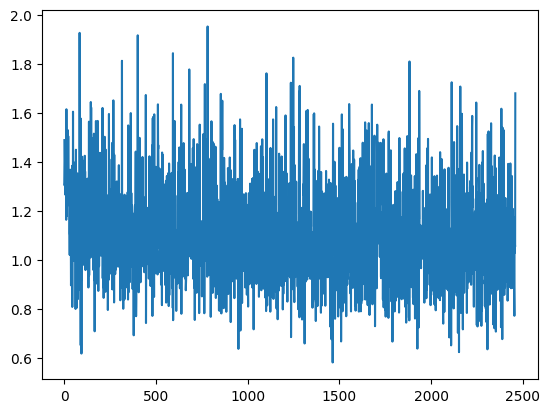

In [24]:
plt.plot(train_losses)

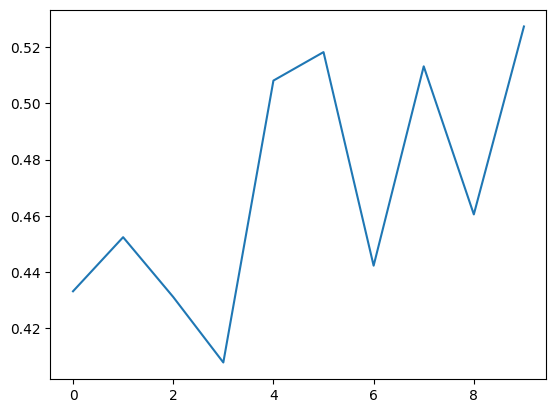

In [25]:
plt.plot(test_accuracy)

In [26]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [27]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 521/976 (0.5338)
{'acc_detail': tensor([0.6471, 0.7189, 0.5140, 0.1232], device='cuda:0'),
 'acc_unweighted': tensor(0.5008, device='cuda:0'),
 'acc_weighted': tensor(0.5338, device='cuda:0'),
 'f1s': tensor(0.4863, device='cuda:0'),
 'f1s_detail': tensor([0.5813, 0.5978, 0.5789, 0.1873], device='cuda:0'),
 'precision_detail': tensor([0.5277, 0.5116, 0.6627, 0.3906], device='cuda:0'),
 'recall_detail': tensor([0.6471, 0.7189, 0.5140, 0.1232], device='cuda:0'),
 'rocauc': tensor([0.8258, 0.7377, 0.8566, 0.7000], device='cuda:0'),
 'uar': tensor(0.5008, device='cuda:0'),
 'wap': tensor(0.5232, device='cuda:0')}


tensor([[143,  52,   4,  22],
        [ 35, 243,  49,  11],
        [  8,  90, 110,   6],
        [ 85,  90,   3,  25]], device='cuda:0')

In [28]:
model_path = '../models_iemocap4/iemocap_label4_m18_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [29]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_iemocap4/iemocap_label4_m18_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                            | 0.003257328990228013/50 [00:00<1:25:03, 102.07s/it]

Train Epoch: 11 [0/3948 (0%)]	Loss: 1.033952
Mem before-during-after: 29950464 2652829696 36459008


  0%|                             | 0.13355048859934857/50 [00:12<1:23:46, 100.80s/it]

Train Epoch: 11 [640/3948 (16%)]	Loss: 1.243325
Mem before-during-after: 36459008 2660268544 36459008


  1%|▏                              | 0.2638436482084691/50 [00:24<1:22:17, 99.27s/it]

Train Epoch: 11 [1280/3948 (33%)]	Loss: 1.403783
Mem before-during-after: 36459008 2660361216 36675072


  1%|▏                              | 0.3941368078175897/50 [00:36<1:21:15, 98.28s/it]

Train Epoch: 11 [1920/3948 (49%)]	Loss: 1.188489
Mem before-during-after: 36675072 2660956672 37363200


  1%|▎                              | 0.5276872964169382/50 [00:48<1:11:22, 86.57s/it]

Train Epoch: 11 [2560/3948 (65%)]	Loss: 0.961570
Mem before-during-after: 36459008 2660268544 36459008


  1%|▍                             | 0.6547231270358308/50 [00:59<1:23:03, 101.00s/it]

Train Epoch: 11 [3200/3948 (81%)]	Loss: 1.193605
Mem before-during-after: 36459008 2660361216 36675072


  2%|▍                              | 0.7850162866449514/50 [01:11<1:21:53, 99.84s/it]

Train Epoch: 11 [3840/3948 (98%)]	Loss: 1.020676
Mem before-during-after: 36675072 2660956672 37363200


  2%|▋                                | 1.0000000000000002/50 [01:25<48:29, 59.37s/it]


Test Epoch: 11	Accuracy: 521/976 (53%)



  2%|▋                                | 1.0032573289902282/50 [01:25<57:02, 69.86s/it]

Train Epoch: 12 [0/3948 (0%)]	Loss: 1.380382
Mem before-during-after: 36454912 2661363200 36459008


  2%|▋                              | 1.1368078175895768/50 [01:37<1:09:51, 85.79s/it]

Train Epoch: 12 [640/3948 (16%)]	Loss: 0.953283
Mem before-during-after: 37363200 2661518848 37363200


  3%|▊                              | 1.2638436482084694/50 [01:48<1:18:50, 97.06s/it]

Train Epoch: 12 [1280/3948 (33%)]	Loss: 1.020332
Mem before-during-after: 37363200 2661518848 37363200


  3%|▉                                | 1.39413680781759/50 [02:00<1:18:37, 97.06s/it]

Train Epoch: 12 [1920/3948 (49%)]	Loss: 0.799868
Mem before-during-after: 37363200 2661518848 37363200


  3%|▉                              | 1.5276872964169386/50 [02:12<1:09:27, 85.98s/it]

Train Epoch: 12 [2560/3948 (65%)]	Loss: 0.856053
Mem before-during-after: 37363200 2661518848 37363200


  3%|█                              | 1.6547231270358311/50 [02:23<1:18:15, 97.12s/it]

Train Epoch: 12 [3200/3948 (81%)]	Loss: 0.790191
Mem before-during-after: 37363200 2661518848 37363200


  4%|█                              | 1.7850162866449517/50 [02:35<1:19:02, 98.36s/it]

Train Epoch: 12 [3840/3948 (98%)]	Loss: 0.784231
Mem before-during-after: 37363200 2661518848 37363200


  4%|█▎                               | 2.0000000000000004/50 [02:48<47:07, 58.91s/it]


Test Epoch: 12	Accuracy: 532/976 (54%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_12epoch.pt


  4%|█▎                               | 2.0032573289902285/50 [02:49<54:31, 68.15s/it]

Train Epoch: 13 [0/3948 (0%)]	Loss: 1.108532
Mem before-during-after: 36454912 2660741632 36459008


  4%|█▎                              | 2.133550488599349/50 [03:00<1:18:32, 98.46s/it]

Train Epoch: 13 [640/3948 (16%)]	Loss: 0.832502
Mem before-during-after: 36459008 2660361216 36675072


  5%|█▍                             | 2.2671009771986976/50 [03:12<1:08:52, 86.58s/it]

Train Epoch: 13 [1280/3948 (33%)]	Loss: 0.926766
Mem before-during-after: 36675072 2660956672 37363200


  5%|█▌                               | 2.39413680781759/50 [03:24<1:19:03, 99.64s/it]

Train Epoch: 13 [1920/3948 (49%)]	Loss: 0.989322
Mem before-during-after: 36459008 2660268544 36459008


  5%|█▌                             | 2.5244299674267108/50 [03:36<1:17:46, 98.30s/it]

Train Epoch: 13 [2560/3948 (65%)]	Loss: 0.956656
Mem before-during-after: 36459008 2660361216 36675072


  5%|█▌                            | 2.6547231270358314/50 [03:48<1:19:37, 100.92s/it]

Train Epoch: 13 [3200/3948 (81%)]	Loss: 0.953287
Mem before-during-after: 36675072 2660956672 37363200


  6%|█▊                              | 2.785016286644952/50 [03:59<1:16:47, 97.59s/it]

Train Epoch: 13 [3840/3948 (98%)]	Loss: 1.106847
Mem before-during-after: 36459008 2660268544 36459008


  6%|██                                | 3.000000000000001/50 [04:13<47:01, 60.04s/it]


Test Epoch: 13	Accuracy: 528/976 (53%)



  6%|██                                | 3.006514657980457/50 [04:14<52:25, 66.94s/it]

Train Epoch: 14 [0/3948 (0%)]	Loss: 0.933736
Mem before-during-after: 36454912 2660741632 36459008


  6%|█▉                             | 3.1335504885993495/50 [04:25<1:17:02, 98.62s/it]

Train Epoch: 14 [640/3948 (16%)]	Loss: 1.097502
Mem before-during-after: 36459008 2660361216 36675072


  7%|██                              | 3.267100977198698/50 [04:37<1:07:46, 87.01s/it]

Train Epoch: 14 [1280/3948 (33%)]	Loss: 1.071154
Mem before-during-after: 36675072 2660956672 37363200


  7%|██                             | 3.3941368078175906/50 [04:49<1:16:20, 98.27s/it]

Train Epoch: 14 [1920/3948 (49%)]	Loss: 1.391501
Mem before-during-after: 36459008 2660268544 36459008


  7%|██▎                             | 3.524429967426711/50 [05:01<1:16:45, 99.09s/it]

Train Epoch: 14 [2560/3948 (65%)]	Loss: 0.999164
Mem before-during-after: 36459008 2660361216 36675072


  7%|██▍                              | 3.65798045602606/50 [05:13<1:07:29, 87.39s/it]

Train Epoch: 14 [3200/3948 (81%)]	Loss: 0.933822
Mem before-during-after: 36675072 2660956672 37363200


  8%|██▎                            | 3.7882736156351804/50 [05:24<1:08:12, 88.55s/it]

Train Epoch: 14 [3840/3948 (98%)]	Loss: 0.799007
Mem before-during-after: 36459008 2660268544 36675072


  8%|██▋                               | 4.000000000000001/50 [05:38<45:49, 59.77s/it]


Test Epoch: 14	Accuracy: 528/976 (53%)



  8%|██▋                               | 4.006514657980456/50 [05:38<51:17, 66.92s/it]

Train Epoch: 15 [0/3948 (0%)]	Loss: 0.950012
Mem before-during-after: 36454912 2661363200 36459008


  8%|██▋                             | 4.133550488599331/50 [05:50<1:14:05, 96.93s/it]

Train Epoch: 15 [640/3948 (16%)]	Loss: 0.977412
Mem before-during-after: 37363200 2661518848 37363200


  9%|██▋                             | 4.263843648208434/50 [06:01<1:14:08, 97.25s/it]

Train Epoch: 15 [1280/3948 (33%)]	Loss: 1.274844
Mem before-during-after: 37363200 2661518848 37363200


  9%|██▊                             | 4.394136807817537/50 [06:13<1:14:31, 98.05s/it]

Train Epoch: 15 [1920/3948 (49%)]	Loss: 1.168938
Mem before-during-after: 37363200 2661518848 37363200


  9%|██▉                              | 4.52442996742664/50 [06:24<1:14:14, 97.96s/it]

Train Epoch: 15 [2560/3948 (65%)]	Loss: 1.031811
Mem before-during-after: 37363200 2661518848 37363200


  9%|███                              | 4.65798045602597/50 [06:37<1:06:17, 87.73s/it]

Train Epoch: 15 [3200/3948 (81%)]	Loss: 1.129296
Mem before-during-after: 36459008 2660376576 36459008


 10%|██▉                            | 4.785016286644845/50 [06:48<1:16:10, 101.09s/it]

Train Epoch: 15 [3840/3948 (98%)]	Loss: 1.242252
Mem before-during-after: 36459008 2660376576 36459008


 10%|███▍                              | 4.999999999999865/50 [07:02<46:15, 61.68s/it]


Test Epoch: 15	Accuracy: 525/976 (53%)



 10%|███▍                              | 5.003257328990093/50 [07:02<53:17, 71.05s/it]

Train Epoch: 16 [0/3948 (0%)]	Loss: 0.810512
Mem before-during-after: 36454912 2660741632 36459008


 10%|███▎                            | 5.133550488599195/50 [07:14<1:13:32, 98.34s/it]

Train Epoch: 16 [640/3948 (16%)]	Loss: 1.117895
Mem before-during-after: 36459008 2660361216 36675072


 11%|███▎                           | 5.263843648208298/50 [07:26<1:14:44, 100.23s/it]

Train Epoch: 16 [1280/3948 (33%)]	Loss: 1.006160
Mem before-during-after: 36675072 2660956672 37363200


 11%|███▍                            | 5.394136807817401/50 [07:38<1:13:58, 99.51s/it]

Train Epoch: 16 [1920/3948 (49%)]	Loss: 1.767350
Mem before-during-after: 36459008 2660268544 36459008


 11%|███▌                            | 5.524429967426504/50 [07:49<1:13:22, 98.98s/it]

Train Epoch: 16 [2560/3948 (65%)]	Loss: 1.017619
Mem before-during-after: 36459008 2660361216 36675072


 11%|███▌                            | 5.654723127035607/50 [08:01<1:13:29, 99.43s/it]

Train Epoch: 16 [3200/3948 (81%)]	Loss: 0.907085
Mem before-during-after: 36675072 2660956672 37363200


 12%|███▌                           | 5.7850162866447095/50 [08:13<1:12:38, 98.58s/it]

Train Epoch: 16 [3840/3948 (98%)]	Loss: 1.030703
Mem before-during-after: 36459008 2660268544 36459008


 12%|████                              | 5.999999999999729/50 [08:27<45:54, 62.61s/it]


Test Epoch: 16	Accuracy: 523/976 (53%)



 12%|████                              | 6.006514657980184/50 [08:27<49:33, 67.58s/it]

Train Epoch: 17 [0/3948 (0%)]	Loss: 1.139851
Mem before-during-after: 36454912 2660741632 36459008


 12%|███▋                          | 6.1335504885990595/50 [08:39<1:13:38, 100.72s/it]

Train Epoch: 17 [640/3948 (16%)]	Loss: 1.249593
Mem before-during-after: 36459008 2660361216 36675072


 13%|████                            | 6.263843648208162/50 [08:51<1:12:39, 99.68s/it]

Train Epoch: 17 [1280/3948 (33%)]	Loss: 1.161063
Mem before-during-after: 36675072 2660956672 37363200


 13%|████                            | 6.394136807817265/50 [09:03<1:11:38, 98.57s/it]

Train Epoch: 17 [1920/3948 (49%)]	Loss: 0.931736
Mem before-during-after: 36459008 2660268544 36459008


 13%|████▏                           | 6.524429967426368/50 [09:14<1:12:08, 99.57s/it]

Train Epoch: 17 [2560/3948 (65%)]	Loss: 1.036035
Mem before-during-after: 37363200 2659364352 36459008


 13%|████▎                           | 6.654723127035471/50 [09:26<1:11:34, 99.09s/it]

Train Epoch: 17 [3200/3948 (81%)]	Loss: 0.890951
Mem before-during-after: 36459008 2658691584 36459008


 14%|████▎                           | 6.785016286644574/50 [09:38<1:11:24, 99.14s/it]

Train Epoch: 17 [3840/3948 (98%)]	Loss: 0.687154
Mem before-during-after: 36459008 2658691584 36459008


 14%|████▊                             | 6.999999999999593/50 [09:52<47:22, 66.10s/it]


Test Epoch: 17	Accuracy: 528/976 (53%)



 14%|████▊                             | 7.006514657980048/50 [09:52<50:16, 70.15s/it]

Train Epoch: 18 [0/3948 (0%)]	Loss: 0.893995
Mem before-during-after: 36454912 2660741632 36459008


 14%|████▌                           | 7.133550488598924/50 [10:04<1:10:22, 98.50s/it]

Train Epoch: 18 [640/3948 (16%)]	Loss: 1.076063
Mem before-during-after: 36459008 2660361216 36675072


 15%|████▋                           | 7.263843648208026/50 [10:16<1:09:58, 98.24s/it]

Train Epoch: 18 [1280/3948 (33%)]	Loss: 0.782319
Mem before-during-after: 36459008 2660268544 36675072


 15%|████▋                           | 7.394136807817129/50 [10:27<1:10:18, 99.02s/it]

Train Epoch: 18 [1920/3948 (49%)]	Loss: 1.113452
Mem before-during-after: 36459008 2660268544 36675072


 15%|████▋                          | 7.524429967426232/50 [10:39<1:13:24, 103.68s/it]

Train Epoch: 18 [2560/3948 (65%)]	Loss: 1.200650
Mem before-during-after: 36459008 2660376576 36459008


 15%|████▉                           | 7.654723127035335/50 [10:51<1:09:54, 99.05s/it]

Train Epoch: 18 [3200/3948 (81%)]	Loss: 1.258965
Mem before-during-after: 36459008 2660376576 36459008


 16%|████▉                           | 7.785016286644438/50 [11:03<1:09:10, 98.31s/it]

Train Epoch: 18 [3840/3948 (98%)]	Loss: 1.259888
Mem before-during-after: 36459008 2660376576 36459008


 16%|█████▍                            | 7.999999999999457/50 [11:16<43:27, 62.07s/it]


Test Epoch: 18	Accuracy: 527/976 (53%)



 16%|█████▍                            | 8.003257328989685/50 [11:17<49:39, 70.94s/it]

Train Epoch: 19 [0/3948 (0%)]	Loss: 0.950078
Mem before-during-after: 36454912 2660741632 36459008


 16%|█████                          | 8.133550488598823/50 [11:29<1:11:13, 102.07s/it]

Train Epoch: 19 [640/3948 (16%)]	Loss: 0.898934
Mem before-during-after: 36459008 2660361216 36675072


 17%|█████                          | 8.263843648207962/50 [11:41<1:10:02, 100.70s/it]

Train Epoch: 19 [1280/3948 (33%)]	Loss: 1.037718
Mem before-during-after: 36675072 2660052480 36459008


 17%|█████▋                            | 8.3941368078171/50 [11:53<1:09:03, 99.58s/it]

Train Epoch: 19 [1920/3948 (49%)]	Loss: 1.270823
Mem before-during-after: 36675072 2660052480 36459008


 17%|█████▎                         | 8.524429967426238/50 [12:05<1:10:38, 102.20s/it]

Train Epoch: 19 [2560/3948 (65%)]	Loss: 0.751489
Mem before-during-after: 36675072 2660052480 36459008


 17%|█████▎                         | 8.654723127035377/50 [12:17<1:12:16, 104.90s/it]

Train Epoch: 19 [3200/3948 (81%)]	Loss: 0.969325
Mem before-during-after: 36675072 2660052480 36459008


 18%|█████▍                         | 8.785016286644515/50 [12:29<1:08:58, 100.42s/it]

Train Epoch: 19 [3840/3948 (98%)]	Loss: 1.201881
Mem before-during-after: 36675072 2660052480 36459008


 18%|██████                            | 8.999999999999593/50 [12:43<42:47, 62.62s/it]


Test Epoch: 19	Accuracy: 524/976 (53%)



 18%|██████▎                            | 9.00651465798005/50 [12:43<46:26, 67.97s/it]

Train Epoch: 20 [0/3948 (0%)]	Loss: 0.906323
Mem before-during-after: 36454912 2660741632 36459008


 18%|██████                           | 9.13355048859896/50 [12:55<1:07:55, 99.72s/it]

Train Epoch: 20 [640/3948 (16%)]	Loss: 0.751492
Mem before-during-after: 36459008 2660361216 36675072


 19%|█████▉                          | 9.267100977198327/50 [13:07<1:00:57, 89.79s/it]

Train Epoch: 20 [1280/3948 (33%)]	Loss: 0.910573
Mem before-during-after: 36675072 2660956672 37363200


 19%|█████▊                         | 9.394136807817237/50 [13:19<1:10:48, 104.62s/it]

Train Epoch: 20 [1920/3948 (49%)]	Loss: 1.112778
Mem before-during-after: 36459008 2660268544 36459008


 19%|█████▉                         | 9.524429967426375/50 [13:31<1:10:15, 104.14s/it]

Train Epoch: 20 [2560/3948 (65%)]	Loss: 0.923264
Mem before-during-after: 36459008 2660361216 36675072


 19%|██████▏                         | 9.657980456025742/50 [13:43<1:00:04, 89.35s/it]

Train Epoch: 20 [3200/3948 (81%)]	Loss: 0.845049
Mem before-during-after: 36675072 2660956672 37363200


 20%|██████▎                         | 9.785016286644652/50 [13:55<1:06:29, 99.19s/it]

Train Epoch: 20 [3840/3948 (98%)]	Loss: 1.043306
Mem before-during-after: 36459008 2660268544 36459008


 20%|██████▉                            | 9.99999999999973/50 [14:09<40:20, 60.50s/it]


Test Epoch: 20	Accuracy: 529/976 (54%)



 20%|██████▌                          | 10.006514657980187/50 [14:09<46:18, 69.48s/it]

Train Epoch: 21 [0/3948 (0%)]	Loss: 1.177411
Mem before-during-after: 36454912 2660741632 36459008


 20%|██████▎                        | 10.133550488599097/50 [14:21<1:05:42, 98.90s/it]

Train Epoch: 21 [640/3948 (16%)]	Loss: 1.017269
Mem before-during-after: 36675072 2660052480 36459008


 21%|██████▊                          | 10.267100977198464/50 [14:33<58:24, 88.20s/it]

Train Epoch: 21 [1280/3948 (33%)]	Loss: 0.724849
Mem before-during-after: 36675072 2660052480 36459008


 21%|██████▍                        | 10.394136807817373/50 [14:44<1:05:17, 98.91s/it]

Train Epoch: 21 [1920/3948 (49%)]	Loss: 1.059744
Mem before-during-after: 36459008 2660376576 36459008


 21%|██████▌                        | 10.524429967426512/50 [14:56<1:04:52, 98.61s/it]

Train Epoch: 21 [2560/3948 (65%)]	Loss: 0.675159
Mem before-during-after: 36459008 2660376576 36459008


 21%|██████▌                        | 10.65472312703565/50 [15:08<1:06:18, 101.11s/it]

Train Epoch: 21 [3200/3948 (81%)]	Loss: 0.761226
Mem before-during-after: 36459008 2660376576 36459008


 22%|██████▍                       | 10.785016286644789/50 [15:20<1:05:30, 100.23s/it]

Train Epoch: 21 [3840/3948 (98%)]	Loss: 0.921943
Mem before-during-after: 36459008 2660376576 36459008


 22%|███████▎                         | 10.999999999999867/50 [15:34<39:58, 61.50s/it]


Test Epoch: 21	Accuracy: 526/976 (53%)



 22%|███████▎                         | 11.006514657980324/50 [15:34<44:20, 68.23s/it]

Train Epoch: 22 [0/3948 (0%)]	Loss: 0.863333
Mem before-during-after: 36454912 2660741632 36459008


 22%|██████▋                       | 11.133550488599234/50 [15:46<1:06:04, 102.02s/it]

Train Epoch: 22 [640/3948 (16%)]	Loss: 0.667993
Mem before-during-after: 36459008 2660361216 36675072


 23%|██████▉                        | 11.263843648208372/50 [15:57<1:04:28, 99.88s/it]

Train Epoch: 22 [1280/3948 (33%)]	Loss: 0.827586
Mem before-during-after: 36675072 2660956672 37363200


 23%|███████▎                        | 11.39413680781751/50 [16:09<1:03:34, 98.81s/it]

Train Epoch: 22 [1920/3948 (49%)]	Loss: 1.011126
Mem before-during-after: 36459008 2660268544 36459008


 23%|███████▏                       | 11.524429967426649/50 [16:21<1:03:19, 98.74s/it]

Train Epoch: 22 [2560/3948 (65%)]	Loss: 0.879583
Mem before-during-after: 36459008 2660361216 36675072


 23%|███████▏                       | 11.654723127035787/50 [16:33<1:03:15, 98.98s/it]

Train Epoch: 22 [3200/3948 (81%)]	Loss: 1.271593
Mem before-during-after: 36675072 2660956672 37363200


 24%|███████▎                       | 11.785016286644925/50 [16:44<1:02:30, 98.13s/it]

Train Epoch: 22 [3840/3948 (98%)]	Loss: 0.937244
Mem before-during-after: 36459008 2660268544 36459008


 24%|███████▉                         | 12.000000000000004/50 [16:58<40:22, 63.74s/it]


Test Epoch: 22	Accuracy: 536/976 (54%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_22epoch.pt


 24%|███████▉                         | 12.003257328990232/50 [16:59<45:30, 71.87s/it]

Train Epoch: 23 [0/3948 (0%)]	Loss: 1.143960
Mem before-during-after: 36454912 2660741632 36459008


 24%|███████▊                        | 12.13355048859937/50 [17:10<1:02:44, 99.41s/it]

Train Epoch: 23 [640/3948 (16%)]	Loss: 1.173274
Mem before-during-after: 36459008 2660361216 36675072


 25%|███████▌                       | 12.263843648208509/50 [17:22<1:02:24, 99.22s/it]

Train Epoch: 23 [1280/3948 (33%)]	Loss: 0.922868
Mem before-during-after: 36675072 2660956672 37363200


 25%|███████▍                      | 12.394136807817647/50 [17:34<1:03:57, 102.05s/it]

Train Epoch: 23 [1920/3948 (49%)]	Loss: 0.963791
Mem before-during-after: 36459008 2660268544 36459008


 25%|███████▌                      | 12.524429967426785/50 [17:46<1:03:28, 101.64s/it]

Train Epoch: 23 [2560/3948 (65%)]	Loss: 1.127084
Mem before-during-after: 36459008 2660361216 36675072


 25%|███████▌                      | 12.654723127035924/50 [17:58<1:02:15, 100.01s/it]

Train Epoch: 23 [3200/3948 (81%)]	Loss: 1.120234
Mem before-during-after: 36675072 2660956672 37363200


 26%|███████▉                       | 12.785016286645062/50 [18:10<1:01:00, 98.36s/it]

Train Epoch: 23 [3840/3948 (98%)]	Loss: 0.928390
Mem before-during-after: 36459008 2660268544 36459008


 26%|████████▊                         | 13.00000000000014/50 [18:24<37:01, 60.04s/it]


Test Epoch: 23	Accuracy: 537/976 (54%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_23epoch.pt


 26%|████████▌                        | 13.006514657980597/50 [18:24<40:49, 66.21s/it]

Train Epoch: 24 [0/3948 (0%)]	Loss: 1.039312
Mem before-during-after: 36454912 2660741632 36459008


 26%|███████▉                      | 13.133550488599507/50 [18:36<1:03:15, 102.96s/it]

Train Epoch: 24 [640/3948 (16%)]	Loss: 1.021709
Mem before-during-after: 36459008 2660361216 36675072


 27%|████████▊                        | 13.267100977198874/50 [18:48<54:09, 88.48s/it]

Train Epoch: 24 [1280/3948 (33%)]	Loss: 0.846936
Mem before-during-after: 36675072 2660956672 37363200


 27%|████████▎                      | 13.394136807817784/50 [19:00<1:00:48, 99.67s/it]

Train Epoch: 24 [1920/3948 (49%)]	Loss: 0.884369
Mem before-during-after: 36459008 2660268544 36459008


 27%|████████▍                      | 13.524429967426922/50 [19:12<1:00:31, 99.56s/it]

Train Epoch: 24 [2560/3948 (65%)]	Loss: 0.915606
Mem before-during-after: 36459008 2660361216 36675072


 27%|█████████▎                        | 13.65472312703606/50 [19:24<59:57, 98.98s/it]

Train Epoch: 24 [3200/3948 (81%)]	Loss: 0.664402
Mem before-during-after: 36459008 2658691584 36459008


 28%|████████▎                     | 13.785016286645199/50 [19:37<1:03:12, 104.73s/it]

Train Epoch: 24 [3840/3948 (98%)]	Loss: 0.995617
Mem before-during-after: 36459008 2658691584 36459008


 28%|█████████▏                       | 14.000000000000277/50 [19:52<36:40, 61.12s/it]


Test Epoch: 24	Accuracy: 541/976 (55%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_24epoch.pt


 28%|█████████▏                       | 14.003257328990506/50 [19:52<44:07, 73.56s/it]

Train Epoch: 25 [0/3948 (0%)]	Loss: 0.999200
Mem before-during-after: 36454912 2660741632 36459008


 28%|█████████▎                       | 14.133550488599644/50 [20:04<59:41, 99.86s/it]

Train Epoch: 25 [640/3948 (16%)]	Loss: 1.088650
Mem before-during-after: 36459008 2660361216 36675072


 29%|█████████▍                       | 14.263843648208782/50 [20:16<58:24, 98.07s/it]

Train Epoch: 25 [1280/3948 (33%)]	Loss: 1.137308
Mem before-during-after: 36675072 2660956672 37363200


 29%|█████████▊                        | 14.39413680781792/50 [20:28<59:01, 99.45s/it]

Train Epoch: 25 [1920/3948 (49%)]	Loss: 1.016087
Mem before-during-after: 36459008 2660268544 36459008


 29%|█████████▌                       | 14.527687296417287/50 [20:40<51:44, 87.51s/it]

Train Epoch: 25 [2560/3948 (65%)]	Loss: 1.525515
Mem before-during-after: 36459008 2660361216 36675072


 29%|████████▊                     | 14.654723127036197/50 [20:52<1:02:12, 105.60s/it]

Train Epoch: 25 [3200/3948 (81%)]	Loss: 1.227319
Mem before-during-after: 36675072 2660956672 37363200


 30%|█████████▍                      | 14.785016286645336/50 [21:04<59:45, 101.83s/it]

Train Epoch: 25 [3840/3948 (98%)]	Loss: 1.047195
Mem before-during-after: 36459008 2660268544 36459008


 30%|█████████▉                       | 15.000000000000414/50 [21:18<35:49, 61.42s/it]


Test Epoch: 25	Accuracy: 533/976 (54%)



 30%|██████████▏                       | 15.00651465798087/50 [21:18<39:14, 67.29s/it]

Train Epoch: 26 [0/3948 (0%)]	Loss: 1.205541
Mem before-during-after: 36454912 2660741632 36459008


 30%|██████████▎                       | 15.13355048859978/50 [21:30<57:23, 98.76s/it]

Train Epoch: 26 [640/3948 (16%)]	Loss: 0.843499
Mem before-during-after: 36459008 2660361216 36675072


 31%|██████████                       | 15.267100977199147/50 [21:42<51:26, 88.86s/it]

Train Epoch: 26 [1280/3948 (33%)]	Loss: 0.805484
Mem before-during-after: 36675072 2660956672 37363200


 31%|█████████▊                      | 15.394136807818057/50 [21:54<57:51, 100.31s/it]

Train Epoch: 26 [1920/3948 (49%)]	Loss: 0.730879
Mem before-during-after: 36675072 2660052480 36459008


 31%|█████████▉                      | 15.524429967427196/50 [22:06<57:29, 100.06s/it]

Train Epoch: 26 [2560/3948 (65%)]	Loss: 1.016071
Mem before-during-after: 36675072 2660052480 36459008


 31%|██████████▎                      | 15.654723127036334/50 [22:18<57:09, 99.86s/it]

Train Epoch: 26 [3200/3948 (81%)]	Loss: 1.103130
Mem before-during-after: 36675072 2660052480 36459008


 32%|██████████▍                      | 15.785016286645472/50 [22:30<56:55, 99.84s/it]

Train Epoch: 26 [3840/3948 (98%)]	Loss: 1.239064
Mem before-during-after: 36675072 2660052480 36459008


 32%|██████████▉                       | 16.00000000000055/50 [22:44<36:08, 63.77s/it]


Test Epoch: 26	Accuracy: 527/976 (53%)



 32%|██████████▌                      | 16.006514657981004/50 [22:44<38:48, 68.51s/it]

Train Epoch: 27 [0/3948 (0%)]	Loss: 0.752912
Mem before-during-after: 36454912 2660741632 36459008


 32%|██████████▋                      | 16.133550488599845/50 [22:56<55:26, 98.23s/it]

Train Epoch: 27 [640/3948 (16%)]	Loss: 1.178269
Mem before-during-after: 36459008 2660361216 36675072


 33%|██████████▋                      | 16.263843648208912/50 [23:07<55:06, 98.01s/it]

Train Epoch: 27 [1280/3948 (33%)]	Loss: 1.097206
Mem before-during-after: 36675072 2660956672 37363200


 33%|███████████▏                      | 16.39413680781798/50 [23:19<55:00, 98.21s/it]

Train Epoch: 27 [1920/3948 (49%)]	Loss: 0.918254
Mem before-during-after: 36459008 2660268544 36459008


 33%|██████████▉                      | 16.524429967427047/50 [23:31<55:35, 99.63s/it]

Train Epoch: 27 [2560/3948 (65%)]	Loss: 0.825471
Mem before-during-after: 36459008 2660361216 36675072


 33%|██████████▉                      | 16.654723127036114/50 [23:43<54:23, 97.87s/it]

Train Epoch: 27 [3200/3948 (81%)]	Loss: 0.958642
Mem before-during-after: 36675072 2660956672 37363200


 34%|███████████▍                      | 16.78501628664518/50 [23:54<55:15, 99.82s/it]

Train Epoch: 27 [3840/3948 (98%)]	Loss: 0.829980
Mem before-during-after: 36459008 2660268544 36675072


 34%|███████████▏                     | 17.000000000000142/50 [24:08<34:19, 62.40s/it]


Test Epoch: 27	Accuracy: 538/976 (54%)



 34%|███████████▏                     | 17.006514657980595/50 [24:09<37:37, 68.41s/it]

Train Epoch: 28 [0/3948 (0%)]	Loss: 0.930344
Mem before-during-after: 36454912 2661363200 36459008


 34%|██████████▉                     | 17.136807817589663/50 [24:21<57:49, 105.56s/it]

Train Epoch: 28 [640/3948 (16%)]	Loss: 0.580676
Mem before-during-after: 37363200 2661518848 37363200


 35%|███████████                     | 17.263843648208503/50 [24:33<54:56, 100.70s/it]

Train Epoch: 28 [1280/3948 (33%)]	Loss: 1.109576
Mem before-during-after: 37363200 2661518848 37363200


 35%|███████████▊                      | 17.39413680781757/50 [24:44<53:09, 97.81s/it]

Train Epoch: 28 [1920/3948 (49%)]	Loss: 0.755664
Mem before-during-after: 37363200 2661518848 37363200


 35%|███████████▏                    | 17.524429967426638/50 [24:56<54:50, 101.31s/it]

Train Epoch: 28 [2560/3948 (65%)]	Loss: 0.715931
Mem before-during-after: 37363200 2661518848 37363200


 35%|███████████▎                    | 17.654723127035705/50 [25:08<55:51, 103.62s/it]

Train Epoch: 28 [3200/3948 (81%)]	Loss: 1.083662
Mem before-during-after: 37363200 2661518848 37363200


 36%|███████████▋                     | 17.785016286644773/50 [25:20<52:49, 98.38s/it]

Train Epoch: 28 [3840/3948 (98%)]	Loss: 0.844189
Mem before-during-after: 37363200 2661518848 37363200


 36%|███████████▉                     | 17.999999999999734/50 [25:34<31:39, 59.37s/it]


Test Epoch: 28	Accuracy: 527/976 (53%)



 36%|████████████▏                     | 18.00325732898996/50 [25:34<36:53, 69.16s/it]

Train Epoch: 29 [0/3948 (0%)]	Loss: 0.933963
Mem before-during-after: 36454912 2660741632 36459008


 36%|███████████▌                    | 18.133550488599028/50 [25:46<53:13, 100.21s/it]

Train Epoch: 29 [640/3948 (16%)]	Loss: 0.903248
Mem before-during-after: 36459008 2660361216 36675072


 37%|███████████▋                    | 18.263843648208095/50 [25:58<54:30, 103.04s/it]

Train Epoch: 29 [1280/3948 (33%)]	Loss: 0.698163
Mem before-during-after: 36675072 2660956672 37363200


 37%|████████████▏                    | 18.394136807817162/50 [26:10<52:06, 98.91s/it]

Train Epoch: 29 [1920/3948 (49%)]	Loss: 1.107949
Mem before-during-after: 36675072 2660052480 36459008


 37%|████████████▏                    | 18.52442996742623/50 [26:22<52:28, 100.04s/it]

Train Epoch: 29 [2560/3948 (65%)]	Loss: 1.024434
Mem before-during-after: 36675072 2660052480 36459008


 37%|███████████▉                    | 18.654723127035297/50 [26:34<52:24, 100.33s/it]

Train Epoch: 29 [3200/3948 (81%)]	Loss: 0.766733
Mem before-during-after: 36675072 2660052480 36459008


 38%|████████████                    | 18.785016286644364/50 [26:46<55:21, 106.39s/it]

Train Epoch: 29 [3840/3948 (98%)]	Loss: 0.968412
Mem before-during-after: 36675072 2660052480 36459008


 38%|████████████▌                    | 18.999999999999325/50 [27:00<32:49, 63.54s/it]


Test Epoch: 29	Accuracy: 532/976 (54%)



 38%|████████████▉                     | 19.00325732898955/50 [27:01<37:19, 72.27s/it]

Train Epoch: 30 [0/3948 (0%)]	Loss: 0.792360
Mem before-during-after: 36454912 2660741632 36459008


 38%|████████████▋                    | 19.13355048859862/50 [27:13<51:45, 100.62s/it]

Train Epoch: 30 [640/3948 (16%)]	Loss: 1.008170
Mem before-during-after: 36459008 2660361216 36675072


 39%|████████████▋                    | 19.267100977197913/50 [27:25<45:20, 88.52s/it]

Train Epoch: 30 [1280/3948 (33%)]	Loss: 1.154781
Mem before-during-after: 36675072 2660956672 37363200


 39%|████████████▊                    | 19.394136807816754/50 [27:37<50:47, 99.59s/it]

Train Epoch: 30 [1920/3948 (49%)]	Loss: 0.891756
Mem before-during-after: 36459008 2660268544 36459008


 39%|████████████▉                    | 19.52442996742582/50 [27:49<50:57, 100.34s/it]

Train Epoch: 30 [2560/3948 (65%)]	Loss: 0.848295
Mem before-during-after: 36459008 2660361216 36675072


 39%|████████████▉                    | 19.654723127034888/50 [28:01<50:08, 99.15s/it]

Train Epoch: 30 [3200/3948 (81%)]	Loss: 0.785573
Mem before-during-after: 36675072 2660956672 37363200


 40%|█████████████                    | 19.785016286643955/50 [28:13<50:01, 99.34s/it]

Train Epoch: 30 [3840/3948 (98%)]	Loss: 1.329715
Mem before-during-after: 36459008 2660268544 36459008


 40%|█████████████▏                   | 19.999999999998916/50 [28:27<30:21, 60.73s/it]


Test Epoch: 30	Accuracy: 520/976 (53%)



 40%|█████████████▏                   | 20.003257328989143/50 [28:27<35:06, 70.23s/it]

Train Epoch: 31 [0/3948 (0%)]	Loss: 0.923775
Mem before-during-after: 36454912 2660741632 36459008


 40%|█████████████▎                   | 20.13355048859821/50 [28:39<49:57, 100.38s/it]

Train Epoch: 31 [640/3948 (16%)]	Loss: 1.046237
Mem before-during-after: 36459008 2660361216 36675072


 41%|████████████▉                   | 20.263843648207278/50 [28:51<50:24, 101.73s/it]

Train Epoch: 31 [1280/3948 (33%)]	Loss: 1.067667
Mem before-during-after: 36459008 2660361216 36675072


 41%|█████████████▍                   | 20.394136807816345/50 [29:03<49:10, 99.65s/it]

Train Epoch: 31 [1920/3948 (49%)]	Loss: 1.274198
Mem before-during-after: 36459008 2660361216 36675072


 41%|█████████████▏                  | 20.524429967425412/50 [29:15<49:14, 100.22s/it]

Train Epoch: 31 [2560/3948 (65%)]	Loss: 1.019534
Mem before-during-after: 36459008 2660361216 36675072


 41%|██████████████                    | 20.65472312703448/50 [29:27<48:16, 98.69s/it]

Train Epoch: 31 [3200/3948 (81%)]	Loss: 0.856819
Mem before-during-after: 36459008 2660361216 36675072


 42%|█████████████▋                   | 20.785016286643547/50 [29:39<48:21, 99.32s/it]

Train Epoch: 31 [3840/3948 (98%)]	Loss: 1.117768
Mem before-during-after: 36459008 2660361216 36675072


 42%|█████████████▊                   | 20.999999999998508/50 [29:52<29:37, 61.29s/it]


Test Epoch: 31	Accuracy: 530/976 (54%)



 42%|█████████████▊                   | 21.003257328988735/50 [29:52<34:38, 71.68s/it]

Train Epoch: 32 [0/3948 (0%)]	Loss: 0.960864
Mem before-during-after: 36454912 2661363200 36459008


 42%|█████████████▉                   | 21.133550488597802/50 [30:04<46:47, 97.24s/it]

Train Epoch: 32 [640/3948 (16%)]	Loss: 1.018137
Mem before-during-after: 37363200 2661518848 37363200


 43%|██████████████▍                   | 21.26384364820687/50 [30:16<46:26, 96.95s/it]

Train Epoch: 32 [1280/3948 (33%)]	Loss: 1.243319
Mem before-during-after: 37363200 2661518848 37363200


 43%|██████████████                   | 21.394136807815936/50 [30:27<46:19, 97.18s/it]

Train Epoch: 32 [1920/3948 (49%)]	Loss: 0.772075
Mem before-during-after: 37363200 2661518848 37363200


 43%|██████████████▏                  | 21.524429967425004/50 [30:39<46:08, 97.24s/it]

Train Epoch: 32 [2560/3948 (65%)]	Loss: 1.291067
Mem before-during-after: 37363200 2661518848 37363200


 43%|██████████████▋                   | 21.65472312703407/50 [30:51<46:59, 99.46s/it]

Train Epoch: 32 [3200/3948 (81%)]	Loss: 1.087478
Mem before-during-after: 37363200 2661518848 37363200


 44%|██████████████▊                   | 21.78501628664314/50 [31:02<46:27, 98.79s/it]

Train Epoch: 32 [3840/3948 (98%)]	Loss: 0.843858
Mem before-during-after: 37363200 2661518848 37363200


 44%|███████████████▍                   | 21.9999999999981/50 [31:16<27:27, 58.85s/it]


Test Epoch: 32	Accuracy: 529/976 (54%)



 44%|██████████████▌                  | 22.006514657978553/50 [31:16<30:51, 66.15s/it]

Train Epoch: 33 [0/3948 (0%)]	Loss: 0.959432
Mem before-during-after: 36454912 2660741632 36459008


 44%|██████████████▌                  | 22.133550488597393/50 [31:28<45:55, 98.89s/it]

Train Epoch: 33 [640/3948 (16%)]	Loss: 1.111686
Mem before-during-after: 36459008 2660361216 36675072


 45%|███████████████▏                  | 22.26384364820646/50 [31:40<45:42, 98.87s/it]

Train Epoch: 33 [1280/3948 (33%)]	Loss: 0.861337
Mem before-during-after: 36675072 2660956672 37363200


 45%|██████████████▊                  | 22.394136807815528/50 [31:51<45:09, 98.17s/it]

Train Epoch: 33 [1920/3948 (49%)]	Loss: 1.037001
Mem before-during-after: 36459008 2660268544 36459008


 45%|██████████████▊                  | 22.524429967424595/50 [32:03<45:43, 99.83s/it]

Train Epoch: 33 [2560/3948 (65%)]	Loss: 1.248019
Mem before-during-after: 36459008 2660361216 36675072


 45%|██████████████▍                 | 22.654723127033662/50 [32:15<47:48, 104.90s/it]

Train Epoch: 33 [3200/3948 (81%)]	Loss: 0.934595
Mem before-during-after: 36675072 2660956672 37363200


 46%|███████████████                  | 22.78501628664273/50 [32:28<49:38, 109.45s/it]

Train Epoch: 33 [3840/3948 (98%)]	Loss: 0.846444
Mem before-during-after: 36459008 2660268544 36459008


 46%|███████████████▋                  | 22.99999999999769/50 [32:42<29:00, 64.47s/it]


Test Epoch: 33	Accuracy: 528/976 (53%)



 46%|███████████████▏                 | 23.006514657978144/50 [32:42<30:43, 68.31s/it]

Train Epoch: 34 [0/3948 (0%)]	Loss: 0.800295
Mem before-during-after: 36454912 2660741632 36459008


 46%|███████████████▎                 | 23.133550488596985/50 [32:54<44:03, 98.39s/it]

Train Epoch: 34 [640/3948 (16%)]	Loss: 0.932551
Mem before-during-after: 36459008 2660361216 36675072


 47%|██████████████▉                 | 23.263843648206052/50 [33:06<44:37, 100.16s/it]

Train Epoch: 34 [1280/3948 (33%)]	Loss: 1.037903
Mem before-during-after: 36675072 2660956672 37363200


 47%|███████████████▉                  | 23.39413680781512/50 [33:18<44:15, 99.82s/it]

Train Epoch: 34 [1920/3948 (49%)]	Loss: 1.109674
Mem before-during-after: 36459008 2660268544 36459008


 47%|███████████████                 | 23.524429967424187/50 [33:31<51:52, 117.56s/it]

Train Epoch: 34 [2560/3948 (65%)]	Loss: 0.718538
Mem before-during-after: 36459008 2660361216 36675072


 47%|███████████████▏                | 23.654723127033254/50 [33:43<44:22, 101.07s/it]

Train Epoch: 34 [3200/3948 (81%)]	Loss: 1.171920
Mem before-during-after: 36675072 2660956672 37363200


 48%|████████████████▏                 | 23.78501628664232/50 [33:54<43:09, 98.79s/it]

Train Epoch: 34 [3840/3948 (98%)]	Loss: 1.150058
Mem before-during-after: 36459008 2660268544 36459008


 48%|███████████████▊                 | 23.999999999997282/50 [34:08<26:30, 61.18s/it]


Test Epoch: 34	Accuracy: 534/976 (54%)



 48%|███████████████▊                 | 24.006514657977736/50 [34:09<28:42, 66.27s/it]

Train Epoch: 35 [0/3948 (0%)]	Loss: 1.056343
Mem before-during-after: 36454912 2660741632 36459008


 48%|███████████████▉                 | 24.136807817586803/50 [34:21<37:33, 87.15s/it]

Train Epoch: 35 [640/3948 (16%)]	Loss: 0.889501
Mem before-during-after: 36459008 2660361216 36675072


 49%|████████████████                 | 24.263843648205643/50 [34:33<42:39, 99.47s/it]

Train Epoch: 35 [1280/3948 (33%)]	Loss: 1.295358
Mem before-during-after: 36675072 2660956672 37363200


 49%|████████████████                 | 24.39413680781471/50 [34:44<43:30, 101.96s/it]

Train Epoch: 35 [1920/3948 (49%)]	Loss: 0.962817
Mem before-during-after: 36675072 2659906048 36459008


 49%|███████████████▋                | 24.524429967423778/50 [34:56<43:47, 103.14s/it]

Train Epoch: 35 [2560/3948 (65%)]	Loss: 1.269173
Mem before-during-after: 36675072 2659906048 36459008


 49%|████████████████▎                | 24.657980456023072/50 [35:09<37:30, 88.79s/it]

Train Epoch: 35 [3200/3948 (81%)]	Loss: 0.724120
Mem before-during-after: 36675072 2659906048 36459008


 50%|████████████████▎                | 24.785016286641913/50 [35:20<42:00, 99.97s/it]

Train Epoch: 35 [3840/3948 (98%)]	Loss: 1.166278
Mem before-during-after: 36675072 2659906048 36459008


 50%|████████████████▍                | 24.999999999996874/50 [35:34<27:20, 65.62s/it]


Test Epoch: 35	Accuracy: 520/976 (53%)



 50%|█████████████████▌                 | 25.0032573289871/50 [35:34<30:23, 72.97s/it]

Train Epoch: 36 [0/3948 (0%)]	Loss: 0.953622
Mem before-during-after: 36454912 2660741632 36459008


 50%|████████████████▌                | 25.136807817586394/50 [35:46<36:10, 87.29s/it]

Train Epoch: 36 [640/3948 (16%)]	Loss: 1.029812
Mem before-during-after: 36459008 2658691584 36459008


 51%|████████████████▏               | 25.263843648205235/50 [35:58<41:22, 100.37s/it]

Train Epoch: 36 [1280/3948 (33%)]	Loss: 1.196489
Mem before-during-after: 36459008 2658691584 36459008


 51%|████████████████▎               | 25.394136807814302/50 [36:10<41:00, 100.01s/it]

Train Epoch: 36 [1920/3948 (49%)]	Loss: 0.888542
Mem before-during-after: 36459008 2658691584 36459008


 51%|█████████████████▎                | 25.52442996742337/50 [36:22<40:31, 99.32s/it]

Train Epoch: 36 [2560/3948 (65%)]	Loss: 0.863659
Mem before-during-after: 36459008 2658691584 36459008


 51%|████████████████▍               | 25.654723127032437/50 [36:34<40:36, 100.08s/it]

Train Epoch: 36 [3200/3948 (81%)]	Loss: 0.994594
Mem before-during-after: 36459008 2658691584 36459008


 52%|████████████████▌               | 25.785016286641504/50 [36:46<41:55, 103.88s/it]

Train Epoch: 36 [3840/3948 (98%)]	Loss: 0.827323
Mem before-during-after: 36459008 2658691584 36459008


 52%|█████████████████▏               | 25.999999999996465/50 [37:00<24:19, 60.81s/it]


Test Epoch: 36	Accuracy: 522/976 (53%)



 52%|█████████████████▋                | 26.00325732898669/50 [37:00<28:51, 72.14s/it]

Train Epoch: 37 [0/3948 (0%)]	Loss: 0.659504
Mem before-during-after: 36454912 2660741632 36459008


 52%|█████████████████▏               | 26.13355048859576/50 [37:12<40:07, 100.86s/it]

Train Epoch: 37 [640/3948 (16%)]	Loss: 0.944552
Mem before-during-after: 36459008 2660361216 36675072


 53%|█████████████████▎               | 26.263843648204826/50 [37:24<39:14, 99.18s/it]

Train Epoch: 37 [1280/3948 (33%)]	Loss: 0.887850
Mem before-during-after: 36675072 2660052480 36459008


 53%|████████████████▉               | 26.394136807813894/50 [37:35<39:36, 100.69s/it]

Train Epoch: 37 [1920/3948 (49%)]	Loss: 0.860564
Mem before-during-after: 36675072 2660052480 36459008


 53%|█████████████████▌               | 26.52442996742296/50 [37:47<39:11, 100.16s/it]

Train Epoch: 37 [2560/3948 (65%)]	Loss: 1.193244
Mem before-during-after: 36675072 2660052480 36459008


 53%|█████████████████▌               | 26.657980456022255/50 [37:59<35:00, 89.99s/it]

Train Epoch: 37 [3200/3948 (81%)]	Loss: 0.926389
Mem before-during-after: 36675072 2660052480 36459008


 54%|█████████████████▋               | 26.785016286641095/50 [38:11<38:34, 99.71s/it]

Train Epoch: 37 [3840/3948 (98%)]	Loss: 1.003498
Mem before-during-after: 36675072 2660052480 36459008


 54%|█████████████████▊               | 26.999999999996056/50 [38:25<23:26, 61.14s/it]


Test Epoch: 37	Accuracy: 529/976 (54%)



 54%|█████████████████▊               | 27.003257328986283/50 [38:25<26:48, 69.95s/it]

Train Epoch: 38 [0/3948 (0%)]	Loss: 0.944402
Mem before-during-after: 36454912 2660741632 36459008


 54%|█████████████████▉               | 27.13355048859535/50 [38:37<38:49, 101.89s/it]

Train Epoch: 38 [640/3948 (16%)]	Loss: 1.101110
Mem before-during-after: 36459008 2660361216 36675072


 55%|█████████████████▍              | 27.263843648204418/50 [38:49<38:27, 101.51s/it]

Train Epoch: 38 [1280/3948 (33%)]	Loss: 1.021099
Mem before-during-after: 36675072 2660956672 37363200


 55%|█████████████████▌              | 27.394136807813485/50 [39:01<39:23, 104.55s/it]

Train Epoch: 38 [1920/3948 (49%)]	Loss: 1.019240
Mem before-during-after: 36459008 2660268544 36459008


 55%|█████████████████▌              | 27.524429967422552/50 [39:13<38:24, 102.51s/it]

Train Epoch: 38 [2560/3948 (65%)]	Loss: 0.968346
Mem before-during-after: 36459008 2660361216 36675072


 55%|██████████████████▊               | 27.65472312703162/50 [39:25<36:46, 98.75s/it]

Train Epoch: 38 [3200/3948 (81%)]	Loss: 0.921378
Mem before-during-after: 36675072 2660956672 37363200


 56%|██████████████████▎              | 27.785016286640687/50 [39:37<36:52, 99.60s/it]

Train Epoch: 38 [3840/3948 (98%)]	Loss: 0.897689
Mem before-during-after: 36675072 2660052480 36459008


 56%|██████████████████▍              | 27.999999999995648/50 [39:51<22:27, 61.27s/it]


Test Epoch: 38	Accuracy: 522/976 (53%)



 56%|███████████████████▌               | 28.0065146579761/50 [39:51<24:41, 67.34s/it]

Train Epoch: 39 [0/3948 (0%)]	Loss: 0.758755
Mem before-during-after: 36454912 2651210240 36879872


 56%|███████████████████▏              | 28.13680781758517/50 [40:03<31:48, 87.29s/it]

Train Epoch: 39 [640/3948 (16%)]	Loss: 0.970324
Mem before-during-after: 36459008 2660268544 36459008


 57%|███████████████████▏              | 28.26384364820401/50 [40:15<35:44, 98.65s/it]

Train Epoch: 39 [1280/3948 (33%)]	Loss: 0.704143
Mem before-during-after: 36459008 2660361216 36675072


 57%|██████████████████▋              | 28.394136807813076/50 [40:26<35:51, 99.57s/it]

Train Epoch: 39 [1920/3948 (49%)]	Loss: 0.840829
Mem before-during-after: 36675072 2660956672 37363200


 57%|███████████████████▍              | 28.52768729641237/50 [40:38<31:56, 89.27s/it]

Train Epoch: 39 [2560/3948 (65%)]	Loss: 0.780512
Mem before-during-after: 36459008 2660268544 36459008


 57%|███████████████████▍              | 28.65472312703121/50 [40:50<35:04, 98.60s/it]

Train Epoch: 39 [3200/3948 (81%)]	Loss: 0.746465
Mem before-during-after: 36459008 2660361216 36675072


 58%|███████████████████              | 28.788273615630505/50 [41:02<31:31, 89.17s/it]

Train Epoch: 39 [3840/3948 (98%)]	Loss: 0.976369
Mem before-during-after: 36675072 2660956672 37363200


 58%|███████████████████▋              | 28.99999999999524/50 [41:16<22:00, 62.89s/it]


Test Epoch: 39	Accuracy: 527/976 (53%)



 58%|███████████████████▏             | 29.003257328985466/50 [41:16<25:32, 72.99s/it]

Train Epoch: 40 [0/3948 (0%)]	Loss: 1.055936
Mem before-during-after: 36454912 2661363200 36459008


 58%|███████████████████▏             | 29.133550488594533/50 [41:27<33:47, 97.14s/it]

Train Epoch: 40 [640/3948 (16%)]	Loss: 1.168733
Mem before-during-after: 37363200 2661518848 37363200


 59%|████████████████████▍              | 29.2638436482036/50 [41:39<33:54, 98.13s/it]

Train Epoch: 40 [1280/3948 (33%)]	Loss: 1.122854
Mem before-during-after: 37363200 2661518848 37363200


 59%|███████████████████▍             | 29.394136807812668/50 [41:51<33:23, 97.23s/it]

Train Epoch: 40 [1920/3948 (49%)]	Loss: 1.165321
Mem before-during-after: 37363200 2661518848 37363200


 59%|██████████████████▉             | 29.524429967421735/50 [42:03<34:23, 100.78s/it]

Train Epoch: 40 [2560/3948 (65%)]	Loss: 0.784373
Mem before-during-after: 36459008 2660376576 36459008


 59%|██████████████████▉             | 29.654723127030802/50 [42:14<34:01, 100.33s/it]

Train Epoch: 40 [3200/3948 (81%)]	Loss: 1.204612
Mem before-during-after: 36459008 2660376576 36459008


 60%|████████████████████▎             | 29.78501628663987/50 [42:26<33:22, 99.06s/it]

Train Epoch: 40 [3840/3948 (98%)]	Loss: 0.747020
Mem before-during-after: 36459008 2660376576 36459008


 60%|████████████████████▍             | 29.99999999999483/50 [42:40<19:53, 59.69s/it]


Test Epoch: 40	Accuracy: 534/976 (54%)



 60%|███████████████████▊             | 30.006514657975284/50 [42:40<21:55, 65.80s/it]

Train Epoch: 41 [0/3948 (0%)]	Loss: 0.932167
Mem before-during-after: 36454912 2660741632 36459008


 60%|███████████████████▉             | 30.133550488594125/50 [42:52<32:51, 99.25s/it]

Train Epoch: 41 [640/3948 (16%)]	Loss: 0.786551
Mem before-during-after: 36459008 2660361216 36675072


 61%|███████████████████▉             | 30.263843648203192/50 [43:04<32:25, 98.55s/it]

Train Epoch: 41 [1280/3948 (33%)]	Loss: 1.141561
Mem before-during-after: 36675072 2660956672 37363200


 61%|████████████████████▋             | 30.39413680781226/50 [43:16<32:36, 99.81s/it]

Train Epoch: 41 [1920/3948 (49%)]	Loss: 0.981749
Mem before-during-after: 36459008 2660268544 36459008


 61%|████████████████████▏            | 30.524429967421327/50 [43:28<31:59, 98.58s/it]

Train Epoch: 41 [2560/3948 (65%)]	Loss: 1.097096
Mem before-during-after: 36459008 2660361216 36675072


 61%|████████████████████▏            | 30.654723127030394/50 [43:39<31:52, 98.88s/it]

Train Epoch: 41 [3200/3948 (81%)]	Loss: 1.140774
Mem before-during-after: 36675072 2660956672 37363200


 62%|████████████████████▉             | 30.78501628663946/50 [43:51<31:44, 99.13s/it]

Train Epoch: 41 [3840/3948 (98%)]	Loss: 1.199063
Mem before-during-after: 36459008 2660268544 36459008


 62%|████████████████████▍            | 30.999999999994422/50 [44:05<19:38, 62.04s/it]


Test Epoch: 41	Accuracy: 514/976 (52%)



 62%|████████████████████▍            | 31.006514657974876/50 [44:05<21:21, 67.48s/it]

Train Epoch: 42 [0/3948 (0%)]	Loss: 0.881067
Mem before-during-after: 36454912 2660741632 36459008


 62%|████████████████████▌            | 31.133550488593716/50 [44:17<31:02, 98.73s/it]

Train Epoch: 42 [640/3948 (16%)]	Loss: 0.656555
Mem before-during-after: 36459008 2660361216 36675072


 63%|█████████████████████▎            | 31.26710097719301/50 [44:29<27:33, 88.26s/it]

Train Epoch: 42 [1280/3948 (33%)]	Loss: 0.950892
Mem before-during-after: 36675072 2660956672 37363200


 63%|█████████████████████▎            | 31.39413680781185/50 [44:41<30:45, 99.17s/it]

Train Epoch: 42 [1920/3948 (49%)]	Loss: 1.179979
Mem before-during-after: 36459008 2660268544 36459008


 63%|████████████████████▊            | 31.527687296411145/50 [44:53<26:53, 87.36s/it]

Train Epoch: 42 [2560/3948 (65%)]	Loss: 0.810497
Mem before-during-after: 36459008 2660361216 36675072


 63%|████████████████████▉            | 31.654723127029985/50 [45:04<29:57, 97.99s/it]

Train Epoch: 42 [3200/3948 (81%)]	Loss: 0.734650
Mem before-during-after: 36675072 2660956672 37363200


 64%|████████████████████▉            | 31.785016286639053/50 [45:16<30:03, 99.00s/it]

Train Epoch: 42 [3840/3948 (98%)]	Loss: 0.914674
Mem before-during-after: 36459008 2660268544 36459008


 64%|█████████████████████            | 31.999999999994014/50 [45:30<17:49, 59.40s/it]


Test Epoch: 42	Accuracy: 516/976 (52%)



 64%|█████████████████████▊            | 32.00651465797447/50 [45:30<20:11, 67.35s/it]

Train Epoch: 43 [0/3948 (0%)]	Loss: 0.918317
Mem before-during-after: 36454912 2660741632 36459008


 64%|█████████████████████▏           | 32.13355048859345/50 [45:42<29:47, 100.07s/it]

Train Epoch: 43 [640/3948 (16%)]	Loss: 1.154894
Mem before-during-after: 36459008 2660361216 36675072


 65%|█████████████████████▉            | 32.26384364820266/50 [45:53<28:56, 97.92s/it]

Train Epoch: 43 [1280/3948 (33%)]	Loss: 0.763043
Mem before-during-after: 36675072 2660956672 37363200


 65%|█████████████████████▍           | 32.39413680781187/50 [46:05<29:24, 100.22s/it]

Train Epoch: 43 [1920/3948 (49%)]	Loss: 0.693431
Mem before-during-after: 36459008 2660268544 36459008


 65%|██████████████████████            | 32.52442996742108/50 [46:17<29:04, 99.82s/it]

Train Epoch: 43 [2560/3948 (65%)]	Loss: 0.908921
Mem before-during-after: 36675072 2659906048 36459008


 65%|██████████████████████▏           | 32.65472312703029/50 [46:29<28:54, 99.98s/it]

Train Epoch: 43 [3200/3948 (81%)]	Loss: 0.792599
Mem before-during-after: 36675072 2659906048 36459008


 66%|██████████████████████▎           | 32.78827361562973/50 [46:41<25:50, 90.06s/it]

Train Epoch: 43 [3840/3948 (98%)]	Loss: 0.981909
Mem before-during-after: 36675072 2659906048 36459008


 66%|██████████████████████▍           | 32.99999999999469/50 [46:55<17:12, 60.72s/it]


Test Epoch: 43	Accuracy: 511/976 (52%)



 66%|██████████████████████▍           | 33.00651465797515/50 [46:55<19:21, 68.33s/it]

Train Epoch: 44 [0/3948 (0%)]	Loss: 0.779094
Mem before-during-after: 36454912 2660741632 36459008


 66%|██████████████████████▌           | 33.13355048859413/50 [47:07<27:46, 98.84s/it]

Train Epoch: 44 [640/3948 (16%)]	Loss: 0.831195
Mem before-during-after: 36459008 2660361216 36675072


 67%|██████████████████████▌           | 33.26384364820334/50 [47:19<27:25, 98.30s/it]

Train Epoch: 44 [1280/3948 (33%)]	Loss: 0.540955
Mem before-during-after: 36675072 2660956672 37363200


 67%|██████████████████████▋           | 33.39413680781255/50 [47:30<27:12, 98.31s/it]

Train Epoch: 44 [1920/3948 (49%)]	Loss: 1.234145
Mem before-during-after: 36459008 2660268544 36459008


 67%|██████████████████████▊           | 33.52442996742176/50 [47:42<27:18, 99.46s/it]

Train Epoch: 44 [2560/3948 (65%)]	Loss: 0.983856
Mem before-during-after: 36459008 2650673152 36459008


 67%|██████████████████████▉           | 33.65472312703097/50 [47:54<27:04, 99.36s/it]

Train Epoch: 44 [3200/3948 (81%)]	Loss: 0.874123
Mem before-during-after: 36675072 2660052480 36459008


 68%|██████████████████████▉           | 33.78827361563041/50 [48:06<24:02, 88.99s/it]

Train Epoch: 44 [3840/3948 (98%)]	Loss: 1.039104
Mem before-during-after: 36675072 2660052480 36459008


 68%|██████████████████████▍          | 33.999999999995374/50 [48:20<16:13, 60.86s/it]


Test Epoch: 44	Accuracy: 508/976 (51%)



 68%|██████████████████████▍          | 34.003257328985605/50 [48:20<18:43, 70.23s/it]

Train Epoch: 45 [0/3948 (0%)]	Loss: 0.846354
Mem before-during-after: 36454912 2660741632 36459008


 68%|██████████████████████▌          | 34.133550488594814/50 [48:32<26:22, 99.76s/it]

Train Epoch: 45 [640/3948 (16%)]	Loss: 0.775120
Mem before-during-after: 36675072 2660052480 36459008


 69%|██████████████████████▌          | 34.267100977194254/50 [48:44<22:56, 87.46s/it]

Train Epoch: 45 [1280/3948 (33%)]	Loss: 0.593528
Mem before-during-after: 36675072 2660052480 36459008


 69%|███████████████████████▍          | 34.39413680781323/50 [48:56<25:44, 98.97s/it]

Train Epoch: 45 [1920/3948 (49%)]	Loss: 0.844681
Mem before-during-after: 36675072 2660052480 36459008


 69%|███████████████████████▍          | 34.52442996742244/50 [49:07<25:25, 98.60s/it]

Train Epoch: 45 [2560/3948 (65%)]	Loss: 0.871295
Mem before-during-after: 36675072 2660052480 36459008


 69%|███████████████████████▌          | 34.65472312703165/50 [49:19<25:31, 99.79s/it]

Train Epoch: 45 [3200/3948 (81%)]	Loss: 0.919532
Mem before-during-after: 36675072 2660052480 36459008


 70%|███████████████████████▋          | 34.78501628664086/50 [49:31<25:00, 98.63s/it]

Train Epoch: 45 [3840/3948 (98%)]	Loss: 1.257487
Mem before-during-after: 36675072 2660052480 36459008


 70%|███████████████████████▊          | 34.99999999999606/50 [49:45<15:14, 60.97s/it]


Test Epoch: 45	Accuracy: 510/976 (52%)



 70%|███████████████████████▊          | 35.00651465797652/50 [49:45<17:00, 68.08s/it]

Train Epoch: 46 [0/3948 (0%)]	Loss: 1.091838
Mem before-during-after: 36454912 2660741632 36459008


 70%|███████████████████████▏         | 35.133550488595496/50 [49:57<24:17, 98.01s/it]

Train Epoch: 46 [640/3948 (16%)]	Loss: 0.697949
Mem before-during-after: 36459008 2660361216 36675072


 71%|███████████████████████▎         | 35.263843648204706/50 [50:09<24:23, 99.35s/it]

Train Epoch: 46 [1280/3948 (33%)]	Loss: 0.853076
Mem before-during-after: 36459008 2660268544 36675072


 71%|███████████████████████▎         | 35.397394136804145/50 [50:21<22:19, 91.76s/it]

Train Epoch: 46 [1920/3948 (49%)]	Loss: 0.734818
Mem before-during-after: 36459008 2660268544 36675072


 71%|██████████████████████▋         | 35.524429967423124/50 [50:32<24:22, 101.03s/it]

Train Epoch: 46 [2560/3948 (65%)]	Loss: 0.777491
Mem before-during-after: 36459008 2660268544 36675072


 71%|███████████████████████▌         | 35.654723127032334/50 [50:44<23:47, 99.53s/it]

Train Epoch: 46 [3200/3948 (81%)]	Loss: 0.856819
Mem before-during-after: 36459008 2660268544 36675072


 72%|███████████████████████▌         | 35.78501628664154/50 [50:56<23:46, 100.33s/it]

Train Epoch: 46 [3840/3948 (98%)]	Loss: 0.766630
Mem before-during-after: 36459008 2660268544 36675072


 72%|████████████████████████▍         | 35.99999999999674/50 [51:10<13:58, 59.91s/it]


Test Epoch: 46	Accuracy: 510/976 (52%)



 72%|████████████████████████▍         | 36.00325732898697/50 [51:10<16:33, 71.02s/it]

Train Epoch: 47 [0/3948 (0%)]	Loss: 1.012264
Mem before-during-after: 36454912 2661363200 36459008


 72%|████████████████████████▌         | 36.13355048859618/50 [51:22<22:32, 97.55s/it]

Train Epoch: 47 [640/3948 (16%)]	Loss: 0.905622
Mem before-during-after: 37363200 2661518848 37363200


 73%|████████████████████████▋         | 36.26384364820539/50 [51:33<22:42, 99.22s/it]

Train Epoch: 47 [1280/3948 (33%)]	Loss: 0.558649
Mem before-during-after: 37363200 2661518848 37363200


 73%|█████████████████████████▍         | 36.3941368078146/50 [51:45<22:09, 97.69s/it]

Train Epoch: 47 [1920/3948 (49%)]	Loss: 0.733216
Mem before-during-after: 37363200 2661518848 37363200


 73%|████████████████████████         | 36.524429967423806/50 [51:57<22:02, 98.17s/it]

Train Epoch: 47 [2560/3948 (65%)]	Loss: 0.712843
Mem before-during-after: 37363200 2661518848 37363200


 73%|████████████████████████▏        | 36.654723127033016/50 [52:08<21:41, 97.56s/it]

Train Epoch: 47 [3200/3948 (81%)]	Loss: 0.856574
Mem before-during-after: 37363200 2661518848 37363200


 74%|████████████████████████▎        | 36.785016286642225/50 [52:20<21:32, 97.78s/it]

Train Epoch: 47 [3840/3948 (98%)]	Loss: 0.897437
Mem before-during-after: 37363200 2661518848 37363200


 74%|█████████████████████████▏        | 36.99999999999742/50 [52:34<13:02, 60.18s/it]


Test Epoch: 47	Accuracy: 517/976 (52%)



 74%|█████████████████████████▏        | 37.00325732898765/50 [52:34<15:16, 70.50s/it]

Train Epoch: 48 [0/3948 (0%)]	Loss: 0.846571
Mem before-during-after: 36454912 2660741632 36459008


 74%|█████████████████████████▎        | 37.13355048859686/50 [52:46<21:03, 98.23s/it]

Train Epoch: 48 [640/3948 (16%)]	Loss: 0.948314
Mem before-during-after: 36459008 2660361216 36675072


 75%|████████████████████████▌        | 37.26384364820607/50 [52:57<22:16, 104.97s/it]

Train Epoch: 48 [1280/3948 (33%)]	Loss: 1.465258
Mem before-during-after: 36675072 2660956672 37363200


 75%|█████████████████████████▍        | 37.39413680781528/50 [53:09<20:50, 99.22s/it]

Train Epoch: 48 [1920/3948 (49%)]	Loss: 0.764478
Mem before-during-after: 36675072 2660052480 36459008


 75%|█████████████████████████▌        | 37.52442996742449/50 [53:21<20:29, 98.53s/it]

Train Epoch: 48 [2560/3948 (65%)]	Loss: 1.025061
Mem before-during-after: 36675072 2660052480 36459008


 75%|██████████████████████████▎        | 37.6547231270337/50 [53:33<20:27, 99.41s/it]

Train Epoch: 48 [3200/3948 (81%)]	Loss: 1.207976
Mem before-during-after: 36675072 2660052480 36459008


 76%|█████████████████████████▋        | 37.78827361563314/50 [53:45<17:48, 87.47s/it]

Train Epoch: 48 [3840/3948 (98%)]	Loss: 0.769363
Mem before-during-after: 36675072 2660052480 36459008


 76%|██████████████████████████▌        | 37.9999999999981/50 [53:58<12:31, 62.63s/it]


Test Epoch: 48	Accuracy: 529/976 (54%)



 76%|█████████████████████████▊        | 38.00325732898833/50 [53:59<14:18, 71.59s/it]

Train Epoch: 49 [0/3948 (0%)]	Loss: 0.668650
Mem before-during-after: 36454912 2660741632 36459008


 76%|█████████████████████████▉        | 38.13355048859754/50 [54:11<19:45, 99.91s/it]

Train Epoch: 49 [640/3948 (16%)]	Loss: 0.926226
Mem before-during-after: 36459008 2660361216 36675072


 77%|██████████████████████████        | 38.26384364820675/50 [54:22<19:21, 99.00s/it]

Train Epoch: 49 [1280/3948 (33%)]	Loss: 1.148031
Mem before-during-after: 36675072 2660956672 37363200


 77%|██████████████████████████        | 38.39413680781596/50 [54:34<19:13, 99.39s/it]

Train Epoch: 49 [1920/3948 (49%)]	Loss: 1.108665
Mem before-during-after: 36675072 2660052480 36459008


 77%|██████████████████████████▏       | 38.52442996742517/50 [54:46<18:54, 98.82s/it]

Train Epoch: 49 [2560/3948 (65%)]	Loss: 0.663979
Mem before-during-after: 36675072 2660052480 36459008


 77%|█████████████████████████▌       | 38.65472312703438/50 [54:58<20:57, 110.81s/it]

Train Epoch: 49 [3200/3948 (81%)]	Loss: 0.734346
Mem before-during-after: 36675072 2660052480 36459008


 78%|█████████████████████████▌       | 38.78501628664359/50 [55:10<18:54, 101.17s/it]

Train Epoch: 49 [3840/3948 (98%)]	Loss: 0.719052
Mem before-during-after: 36675072 2660052480 36459008


 78%|█████████████████████████▋       | 38.999999999998785/50 [55:24<11:07, 60.64s/it]


Test Epoch: 49	Accuracy: 484/976 (49%)



 78%|█████████████████████████▋       | 39.003257328989015/50 [55:24<12:53, 70.34s/it]

Train Epoch: 50 [0/3948 (0%)]	Loss: 0.771075
Mem before-during-after: 36454912 2660741632 36459008


 78%|█████████████████████████▊       | 39.133550488598225/50 [55:36<17:46, 98.14s/it]

Train Epoch: 50 [640/3948 (16%)]	Loss: 1.017725
Mem before-during-after: 36459008 2660361216 36675072


 79%|█████████████████████████▉       | 39.263843648207434/50 [55:48<17:39, 98.66s/it]

Train Epoch: 50 [1280/3948 (33%)]	Loss: 0.866973
Mem before-during-after: 36675072 2659906048 36459008


 79%|██████████████████████████       | 39.39413680781664/50 [55:59<17:41, 100.05s/it]

Train Epoch: 50 [1920/3948 (49%)]	Loss: 0.828184
Mem before-during-after: 36675072 2659906048 36459008


 79%|██████████████████████████       | 39.52442996742585/50 [56:11<17:30, 100.28s/it]

Train Epoch: 50 [2560/3948 (65%)]	Loss: 0.666420
Mem before-during-after: 36675072 2659906048 36459008


 79%|██████████████████████████▏      | 39.65472312703506/50 [56:23<17:27, 101.24s/it]

Train Epoch: 50 [3200/3948 (81%)]	Loss: 0.943276
Mem before-during-after: 36675072 2659906048 36459008


 80%|███████████████████████████       | 39.78501628664427/50 [56:35<16:50, 98.89s/it]

Train Epoch: 50 [3840/3948 (98%)]	Loss: 0.859453
Mem before-during-after: 36675072 2659906048 36459008


 80%|███████████████████████████▏      | 39.99999999999947/50 [56:49<10:05, 60.54s/it]


Test Epoch: 50	Accuracy: 524/976 (53%)



 80%|███████████████████████████▏      | 40.00651465797993/50 [56:49<11:13, 67.42s/it]

Train Epoch: 51 [0/3948 (0%)]	Loss: 0.908171
Mem before-during-after: 36454912 2660741632 36459008


 80%|███████████████████████████▎      | 40.13355048859891/50 [57:01<16:06, 97.98s/it]

Train Epoch: 51 [640/3948 (16%)]	Loss: 1.083269
Mem before-during-after: 36459008 2660361216 36675072


 81%|██████████████████████████▌      | 40.263843648208116/50 [57:13<16:02, 98.83s/it]

Train Epoch: 51 [1280/3948 (33%)]	Loss: 0.637391
Mem before-during-after: 36675072 2659906048 36459008


 81%|██████████████████████████▋      | 40.394136807817326/50 [57:24<15:51, 99.08s/it]

Train Epoch: 51 [1920/3948 (49%)]	Loss: 0.683731
Mem before-during-after: 36675072 2659906048 36459008


 81%|██████████████████████████▋      | 40.524429967426535/50 [57:36<15:28, 98.03s/it]

Train Epoch: 51 [2560/3948 (65%)]	Loss: 0.722414
Mem before-during-after: 36459008 2660361216 36675072


 81%|██████████████████████████      | 40.654723127035744/50 [57:48<15:37, 100.27s/it]

Train Epoch: 51 [3200/3948 (81%)]	Loss: 0.887613
Mem before-during-after: 36459008 2660361216 36675072


 82%|██████████████████████████▉      | 40.785016286644954/50 [58:00<15:10, 98.76s/it]

Train Epoch: 51 [3840/3948 (98%)]	Loss: 0.837735
Mem before-during-after: 36459008 2660361216 36675072


 82%|███████████████████████████▉      | 41.00000000000015/50 [58:14<09:11, 61.25s/it]


Test Epoch: 51	Accuracy: 519/976 (53%)



 82%|███████████████████████████▉      | 41.00651465798061/50 [58:14<10:17, 68.63s/it]

Train Epoch: 52 [0/3948 (0%)]	Loss: 0.939850
Mem before-during-after: 36454912 2660741632 36459008


 82%|███████████████████████████▉      | 41.13355048859959/50 [58:26<14:31, 98.29s/it]

Train Epoch: 52 [640/3948 (16%)]	Loss: 1.042388
Mem before-during-after: 36459008 2660361216 36675072


 83%|████████████████████████████▉      | 41.2638436482088/50 [58:37<14:16, 98.02s/it]

Train Epoch: 52 [1280/3948 (33%)]	Loss: 0.636409
Mem before-during-after: 36675072 2660956672 37363200


 83%|████████████████████████████▏     | 41.39413680781801/50 [58:49<14:08, 98.55s/it]

Train Epoch: 52 [1920/3948 (49%)]	Loss: 0.976885
Mem before-during-after: 36459008 2660268544 36459008


 83%|████████████████████████████▏     | 41.52442996742722/50 [59:01<13:58, 98.95s/it]

Train Epoch: 52 [2560/3948 (65%)]	Loss: 0.860252
Mem before-during-after: 36459008 2660361216 36675072


 83%|██████████████████████████▋     | 41.654723127036426/50 [59:13<14:24, 103.58s/it]

Train Epoch: 52 [3200/3948 (81%)]	Loss: 0.899878
Mem before-during-after: 36675072 2660956672 37363200


 84%|███████████████████████████▌     | 41.785016286645636/50 [59:25<13:37, 99.51s/it]

Train Epoch: 52 [3840/3948 (98%)]	Loss: 1.041467
Mem before-during-after: 36459008 2660268544 36459008


 84%|████████████████████████████▌     | 42.00000000000083/50 [59:39<08:17, 62.20s/it]


Test Epoch: 52	Accuracy: 507/976 (51%)



 84%|████████████████████████████▌     | 42.00325732899106/50 [59:39<09:38, 72.32s/it]

Train Epoch: 53 [0/3948 (0%)]	Loss: 0.748628
Mem before-during-after: 36454912 2660741632 36459008


 84%|████████████████████████████▋     | 42.13355048860027/50 [59:51<12:58, 98.96s/it]

Train Epoch: 53 [640/3948 (16%)]	Loss: 0.751560
Mem before-during-after: 36459008 2660268544 36675072


 85%|██████████████████████████▏    | 42.26384364820948/50 [1:00:02<12:54, 100.06s/it]

Train Epoch: 53 [1280/3948 (33%)]	Loss: 0.698293
Mem before-during-after: 36459008 2660268544 36675072


 85%|███████████████████████████▏    | 42.39413680781869/50 [1:00:14<12:40, 99.96s/it]

Train Epoch: 53 [1920/3948 (49%)]	Loss: 0.990698
Mem before-during-after: 36459008 2660268544 36675072


 85%|████████████████████████████     | 42.5244299674279/50 [1:00:26<12:26, 99.91s/it]

Train Epoch: 53 [2560/3948 (65%)]	Loss: 0.722308
Mem before-during-after: 36459008 2660268544 36675072


 85%|███████████████████████████▎    | 42.65472312703711/50 [1:00:38<12:08, 99.19s/it]

Train Epoch: 53 [3200/3948 (81%)]	Loss: 1.174615
Mem before-during-after: 36459008 2660268544 36675072


 86%|███████████████████████████▍    | 42.78501628664632/50 [1:00:50<11:59, 99.66s/it]

Train Epoch: 53 [3840/3948 (98%)]	Loss: 0.964271
Mem before-during-after: 36459008 2660268544 36675072


 86%|███████████████████████████▌    | 43.00000000000151/50 [1:01:04<07:09, 61.35s/it]


Test Epoch: 53	Accuracy: 502/976 (51%)



 86%|██████████████████████████▋    | 43.003257328991744/50 [1:01:04<08:17, 71.14s/it]

Train Epoch: 54 [0/3948 (0%)]	Loss: 0.874061
Mem before-during-after: 36454912 2661363200 36459008


 86%|██████████████████████████▋    | 43.13355048860095/50 [1:01:16<11:33, 100.97s/it]

Train Epoch: 54 [640/3948 (16%)]	Loss: 0.897938
Mem before-during-after: 36459008 2660376576 36459008


 87%|███████████████████████████▋    | 43.26384364821016/50 [1:01:27<11:01, 98.18s/it]

Train Epoch: 54 [1280/3948 (33%)]	Loss: 0.763214
Mem before-during-after: 36459008 2658691584 36459008


 87%|███████████████████████████▊    | 43.39413680781937/50 [1:01:39<10:53, 98.91s/it]

Train Epoch: 54 [1920/3948 (49%)]	Loss: 0.976393
Mem before-during-after: 36459008 2658691584 36459008


 87%|██████████████████████████▉    | 43.52442996742858/50 [1:01:51<10:47, 100.04s/it]

Train Epoch: 54 [2560/3948 (65%)]	Loss: 1.107632
Mem before-during-after: 36459008 2658691584 36459008


 87%|███████████████████████████▉    | 43.65472312703779/50 [1:02:03<10:30, 99.36s/it]

Train Epoch: 54 [3200/3948 (81%)]	Loss: 0.765427
Mem before-during-after: 36459008 2658691584 36459008


 88%|█████████████████████████████▊    | 43.785016286647/50 [1:02:15<10:15, 98.98s/it]

Train Epoch: 54 [3840/3948 (98%)]	Loss: 0.940345
Mem before-during-after: 36459008 2658691584 36459008


 88%|███████████████████████████▎   | 44.000000000002196/50 [1:02:29<06:06, 61.13s/it]


Test Epoch: 54	Accuracy: 490/976 (50%)



 88%|███████████████████████████▎   | 44.006514657982656/50 [1:02:29<06:52, 68.89s/it]

Train Epoch: 55 [0/3948 (0%)]	Loss: 0.869459
Mem before-during-after: 36454912 2660741632 36459008


 88%|██████████████████████████▍   | 44.133550488601635/50 [1:02:41<10:45, 110.00s/it]

Train Epoch: 55 [640/3948 (16%)]	Loss: 0.741175
Mem before-during-after: 36459008 2660361216 36675072


 89%|██████████████████████████▌   | 44.263843648210845/50 [1:02:53<09:33, 100.05s/it]

Train Epoch: 55 [1280/3948 (33%)]	Loss: 0.559789
Mem before-during-after: 36675072 2659906048 36459008


 89%|██████████████████████████▋   | 44.394136807820054/50 [1:03:05<09:20, 100.04s/it]

Train Epoch: 55 [1920/3948 (49%)]	Loss: 1.195847
Mem before-during-after: 36675072 2659906048 36459008


 89%|████████████████████████████▍   | 44.52442996742926/50 [1:03:16<08:57, 98.13s/it]

Train Epoch: 55 [2560/3948 (65%)]	Loss: 0.790293
Mem before-during-after: 36675072 2659906048 36459008


 89%|████████████████████████████▌   | 44.65472312703847/50 [1:03:28<08:44, 98.06s/it]

Train Epoch: 55 [3200/3948 (81%)]	Loss: 0.904149
Mem before-during-after: 36675072 2659906048 36459008


 90%|████████████████████████████▋   | 44.78501628664768/50 [1:03:40<08:32, 98.34s/it]

Train Epoch: 55 [3840/3948 (98%)]	Loss: 0.917117
Mem before-during-after: 36675072 2659906048 36459008


 90%|████████████████████████████▊   | 45.00000000000288/50 [1:03:54<05:03, 60.64s/it]


Test Epoch: 55	Accuracy: 497/976 (50%)



 90%|████████████████████████████▊   | 45.00651465798334/50 [1:03:54<05:31, 66.39s/it]

Train Epoch: 56 [0/3948 (0%)]	Loss: 0.540334
Mem before-during-after: 36454912 2660741632 36459008


 90%|████████████████████████████▉   | 45.13355048860232/50 [1:04:06<07:59, 98.50s/it]

Train Epoch: 56 [640/3948 (16%)]	Loss: 0.785524
Mem before-during-after: 36459008 2660361216 36675072


 91%|████████████████████████████▉   | 45.26384364821153/50 [1:04:17<07:52, 99.74s/it]

Train Epoch: 56 [1280/3948 (33%)]	Loss: 1.146033
Mem before-during-after: 36675072 2660956672 37363200


 91%|████████████████████████████▏  | 45.394136807820736/50 [1:04:29<07:36, 99.17s/it]

Train Epoch: 56 [1920/3948 (49%)]	Loss: 0.961005
Mem before-during-after: 36459008 2660268544 36459008


 91%|████████████████████████████▏  | 45.524429967429946/50 [1:04:41<07:20, 98.36s/it]

Train Epoch: 56 [2560/3948 (65%)]	Loss: 0.845897
Mem before-during-after: 36675072 2660052480 36459008


 91%|███████████████████████████▍  | 45.654723127039155/50 [1:04:53<07:20, 101.32s/it]

Train Epoch: 56 [3200/3948 (81%)]	Loss: 0.636891
Mem before-during-after: 36675072 2660052480 36459008


 92%|████████████████████████████▍  | 45.785016286648364/50 [1:05:05<07:00, 99.77s/it]

Train Epoch: 56 [3840/3948 (98%)]	Loss: 1.113845
Mem before-during-after: 36459008 2658691584 36459008


 92%|█████████████████████████████▍  | 46.00000000000356/50 [1:05:19<04:01, 60.35s/it]


Test Epoch: 56	Accuracy: 511/976 (52%)



 92%|█████████████████████████████▍  | 46.00651465798402/50 [1:05:19<04:25, 66.47s/it]

Train Epoch: 57 [0/3948 (0%)]	Loss: 0.818887
Mem before-during-after: 36454912 2660741632 36459008


 92%|███████████████████████████████▎  | 46.133550488603/50 [1:05:31<06:21, 98.78s/it]

Train Epoch: 57 [640/3948 (16%)]	Loss: 1.028313
Mem before-during-after: 36459008 2660361216 36675072


 93%|████████████████████████████▋  | 46.26384364821221/50 [1:05:44<06:30, 104.49s/it]

Train Epoch: 57 [1280/3948 (33%)]	Loss: 0.631386
Mem before-during-after: 36675072 2660956672 37363200


 93%|█████████████████████████████▋  | 46.39413680782142/50 [1:05:56<06:00, 99.92s/it]

Train Epoch: 57 [1920/3948 (49%)]	Loss: 0.604622
Mem before-during-after: 36459008 2660268544 36459008


 93%|█████████████████████████████▊  | 46.52768729642086/50 [1:06:08<05:03, 87.29s/it]

Train Epoch: 57 [2560/3948 (65%)]	Loss: 0.935876
Mem before-during-after: 36459008 2660361216 36675072


 93%|█████████████████████████████▊  | 46.65472312703984/50 [1:06:19<05:29, 98.38s/it]

Train Epoch: 57 [3200/3948 (81%)]	Loss: 0.832879
Mem before-during-after: 36675072 2660956672 37363200


 94%|█████████████████████████████  | 46.785016286649046/50 [1:06:31<05:20, 99.58s/it]

Train Epoch: 57 [3840/3948 (98%)]	Loss: 0.838387
Mem before-during-after: 36459008 2660268544 36459008


 94%|██████████████████████████████  | 47.00000000000424/50 [1:06:45<03:07, 62.39s/it]


Test Epoch: 57	Accuracy: 500/976 (51%)



 94%|███████████████████████████████  | 47.0065146579847/50 [1:06:45<03:22, 67.48s/it]

Train Epoch: 58 [0/3948 (0%)]	Loss: 0.568172
Mem before-during-after: 36454912 2660741632 36459008


 94%|██████████████████████████████▏ | 47.13355048860368/50 [1:06:57<04:46, 99.78s/it]

Train Epoch: 58 [640/3948 (16%)]	Loss: 0.777248
Mem before-during-after: 36459008 2660361216 36675072


 95%|██████████████████████████████▏ | 47.26384364821289/50 [1:07:09<04:31, 99.32s/it]

Train Epoch: 58 [1280/3948 (33%)]	Loss: 1.070122
Mem before-during-after: 36675072 2660956672 37363200


 95%|███████████████████████████████▎ | 47.3941368078221/50 [1:07:21<04:17, 98.78s/it]

Train Epoch: 58 [1920/3948 (49%)]	Loss: 0.821378
Mem before-during-after: 36459008 2660268544 36459008


 95%|██████████████████████████████▍ | 47.52442996743131/50 [1:07:33<04:06, 99.63s/it]

Train Epoch: 58 [2560/3948 (65%)]	Loss: 0.934602
Mem before-during-after: 36459008 2660361216 36675072


 95%|██████████████████████████████▍ | 47.65472312704052/50 [1:07:45<03:51, 98.84s/it]

Train Epoch: 58 [3200/3948 (81%)]	Loss: 1.038345
Mem before-during-after: 36675072 2660956672 37363200


 96%|██████████████████████████████▌ | 47.78501628664973/50 [1:07:56<03:40, 99.68s/it]

Train Epoch: 58 [3840/3948 (98%)]	Loss: 1.371315
Mem before-during-after: 36459008 2660268544 36459008


 96%|█████████████████████████████▊ | 48.000000000004924/50 [1:08:11<02:05, 62.63s/it]


Test Epoch: 58	Accuracy: 478/976 (48%)



 96%|█████████████████████████████▊ | 48.006514657985385/50 [1:08:12<02:15, 67.87s/it]

Train Epoch: 59 [0/3948 (0%)]	Loss: 1.027915
Mem before-during-after: 36454912 2660741632 36459008


 96%|█████████████████████████████▊ | 48.136807817594594/50 [1:08:24<02:45, 88.75s/it]

Train Epoch: 59 [640/3948 (16%)]	Loss: 0.527161
Mem before-during-after: 36459008 2660361216 36675072


 97%|██████████████████████████████▉ | 48.26384364821357/50 [1:08:36<02:50, 98.44s/it]

Train Epoch: 59 [1280/3948 (33%)]	Loss: 0.917831
Mem before-during-after: 36675072 2660956672 37363200


 97%|██████████████████████████████▉ | 48.39413680782278/50 [1:08:47<02:37, 97.91s/it]

Train Epoch: 59 [1920/3948 (49%)]	Loss: 0.743883
Mem before-during-after: 36459008 2660268544 36459008


 97%|███████████████████████████████ | 48.52442996743199/50 [1:08:59<02:26, 99.02s/it]

Train Epoch: 59 [2560/3948 (65%)]	Loss: 0.608969
Mem before-during-after: 36459008 2660361216 36675072


 97%|████████████████████████████████ | 48.6547231270412/50 [1:09:11<02:13, 99.12s/it]

Train Epoch: 59 [3200/3948 (81%)]	Loss: 0.561178
Mem before-during-after: 36675072 2660956672 37363200


 98%|███████████████████████████████▏| 48.78501628665041/50 [1:09:23<02:00, 99.49s/it]

Train Epoch: 59 [3840/3948 (98%)]	Loss: 0.960483
Mem before-during-after: 36459008 2660268544 36459008


 98%|██████████████████████████████▍| 49.000000000005606/50 [1:09:36<01:01, 61.38s/it]


Test Epoch: 59	Accuracy: 484/976 (49%)



 98%|██████████████████████████████▍| 49.003257328995836/50 [1:09:37<01:10, 70.80s/it]

Train Epoch: 60 [0/3948 (0%)]	Loss: 0.766005
Mem before-during-after: 36454912 2660741632 36459008


 98%|█████████████████████████████▍| 49.133550488605046/50 [1:09:49<01:27, 101.02s/it]

Train Epoch: 60 [640/3948 (16%)]	Loss: 0.825273
Mem before-during-after: 36459008 2660361216 36675072


 99%|██████████████████████████████▌| 49.263843648214255/50 [1:10:01<01:12, 98.78s/it]

Train Epoch: 60 [1280/3948 (33%)]	Loss: 0.799928
Mem before-during-after: 36675072 2660956672 37363200


 99%|██████████████████████████████▌| 49.394136807823465/50 [1:10:12<00:59, 98.78s/it]

Train Epoch: 60 [1920/3948 (49%)]	Loss: 1.086127
Mem before-during-after: 36459008 2660268544 36459008


 99%|██████████████████████████████▋| 49.524429967432674/50 [1:10:24<00:46, 98.04s/it]

Train Epoch: 60 [2560/3948 (65%)]	Loss: 0.854631
Mem before-during-after: 36459008 2650673152 36459008


 99%|███████████████████████████████▊| 49.65472312704188/50 [1:10:36<00:34, 99.17s/it]

Train Epoch: 60 [3200/3948 (81%)]	Loss: 0.858156
Mem before-during-after: 36675072 2660052480 36459008


100%|██████████████████████████████▊| 49.78501628665109/50 [1:10:48<00:21, 101.47s/it]

Train Epoch: 60 [3840/3948 (98%)]	Loss: 0.542219
Mem before-during-after: 36675072 2660052480 36459008


100%|███████████████████████████████▉| 49.99674267101606/50 [1:11:01<00:00, 62.83s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████| 50.00000000000629/50 [1:11:02<00:00, 85.24s/it]


Test Epoch: 60	Accuracy: 495/976 (50%)



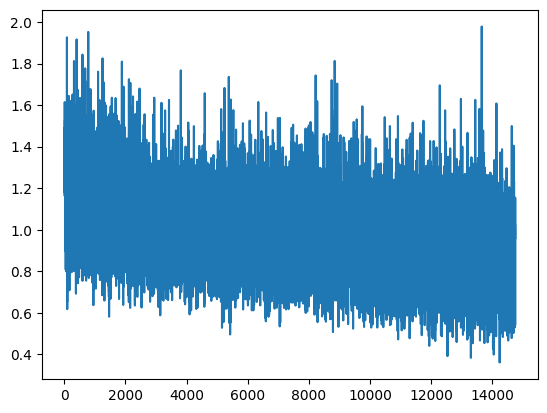

In [30]:
plt.plot(train_losses)

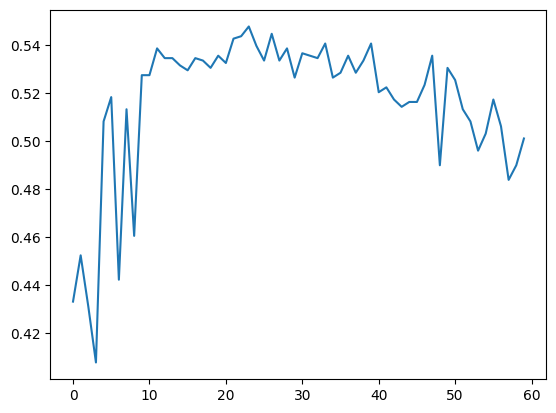

In [31]:
plt.plot(test_accuracy)

In [32]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 495/976 (0.5072)
{'acc_detail': tensor([0.4525, 0.7130, 0.4766, 0.2562], device='cuda:0'),
 'acc_unweighted': tensor(0.4746, device='cuda:0'),
 'acc_weighted': tensor(0.5072, device='cuda:0'),
 'f1s': tensor(0.4803, device='cuda:0'),
 'f1s_detail': tensor([0.5115, 0.5821, 0.5271, 0.3006], device='cuda:0'),
 'precision_detail': tensor([0.5882, 0.4918, 0.5896, 0.3636], device='cuda:0'),
 'recall_detail': tensor([0.4525, 0.7130, 0.4766, 0.2562], device='cuda:0'),
 'rocauc': tensor([0.8114, 0.7128, 0.8428, 0.6994], device='cuda:0'),
 'uar': tensor(0.4746, device='cuda:0'),
 'wap': tensor(0.5084, device='cuda:0')}


tensor([[100,  64,   6,  51],
        [ 16, 241,  52,  29],
        [  5,  96, 102,  11],
        [ 49,  89,  13,  52]], device='cuda:0')

In [33]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_iemocap4/iemocap_label4_m18_best_24epoch.pt
Correct: 541/976 (0.5543)
{'acc_detail': tensor([0.6425, 0.7751, 0.4299, 0.2217], device='cuda:0'),
 'acc_unweighted': tensor(0.5173, device='cuda:0'),
 'acc_weighted': tensor(0.5543, device='cuda:0'),
 'f1s': tensor(0.5172, device='cuda:0'),
 'f1s_detail': tensor([0.6174, 0.6298, 0.5396, 0.2821], device='cuda:0'),
 'precision_detail': tensor([0.5941, 0.5304, 0.7244, 0.3879], device='cuda:0'),
 'recall_detail': tensor([0.6425, 0.7751, 0.4299, 0.2217], device='cuda:0'),
 'rocauc': tensor([0.8362, 0.7383, 0.8588, 0.7149], device='cuda:0'),
 'uar': tensor(0.5173, device='cuda:0'),
 'wap': tensor(0.5577, device='cuda:0')}


tensor([[142,  45,   3,  31],
        [ 20, 262,  27,  29],
        [  6, 105,  92,  11],
        [ 71,  82,   5,  45]], device='cuda:0')

In [34]:
np.save('../models_iemocap4/iemocap4_m18_60epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_iemocap4/iemocap4_m18_60epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [36]:
checkpoint_path = '../models_iemocap4/iemocap4_m18_60epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [37]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                             | 0.003257328990228013/40 [00:00<1:03:35, 95.40s/it]

Train Epoch: 61 [0/3948 (0%)]	Loss: 0.516907
Mem before-during-after: 37555712 2660570112 44707328


  0%|                             | 0.13355048859934857/40 [00:12<1:06:38, 100.30s/it]

Train Epoch: 61 [640/3948 (16%)]	Loss: 0.450343
Mem before-during-after: 44175872 2668805632 44175872


  1%|▏                             | 0.2638436482084691/40 [00:24<1:07:00, 101.18s/it]

Train Epoch: 61 [1280/3948 (33%)]	Loss: 0.626387
Mem before-during-after: 44175872 2668805632 44175872


  1%|▎                             | 0.3941368078175897/40 [00:36<1:06:04, 100.09s/it]

Train Epoch: 61 [1920/3948 (49%)]	Loss: 0.887125
Mem before-during-after: 44280320 2667792896 44280320


  1%|▍                             | 0.5244299674267102/40 [00:48<1:06:50, 101.59s/it]

Train Epoch: 61 [2560/3948 (65%)]	Loss: 1.473819
Mem before-during-after: 44280320 2667792896 44280320


  2%|▍                             | 0.6547231270358308/40 [01:00<1:06:30, 101.42s/it]

Train Epoch: 61 [3200/3948 (81%)]	Loss: 0.887861
Mem before-during-after: 44280320 2667792896 44280320


  2%|▌                              | 0.7850162866449514/40 [01:12<1:05:12, 99.78s/it]

Train Epoch: 61 [3840/3948 (98%)]	Loss: 0.743697
Mem before-during-after: 44280320 2667792896 44280320


  3%|▊                                | 1.0000000000000002/40 [01:26<40:11, 61.84s/it]


Test Epoch: 61	Accuracy: 484/976 (49%)



  3%|▊                                | 1.0065146579804563/40 [01:26<44:40, 68.74s/it]

Train Epoch: 62 [0/3948 (0%)]	Loss: 1.040102
Mem before-during-after: 44060160 2667963392 44923392


  3%|▉                              | 1.1335504885993488/40 [01:38<1:04:43, 99.92s/it]

Train Epoch: 62 [640/3948 (16%)]	Loss: 0.664264
Mem before-during-after: 45081600 2667388416 44175872


  3%|▉                             | 1.2638436482084694/40 [01:50<1:05:58, 102.19s/it]

Train Epoch: 62 [1280/3948 (33%)]	Loss: 0.507706
Mem before-during-after: 44175872 2669411328 45081600


  3%|█▏                               | 1.39413680781759/40 [02:02<1:03:30, 98.71s/it]

Train Epoch: 62 [1920/3948 (49%)]	Loss: 0.672864
Mem before-during-after: 45081600 2669006336 45081600


  4%|█▏                             | 1.5244299674267106/40 [02:13<1:03:13, 98.61s/it]

Train Epoch: 62 [2560/3948 (65%)]	Loss: 0.881705
Mem before-during-after: 45081600 2667388416 44175872


  4%|█▎                             | 1.6547231270358311/40 [02:25<1:03:14, 98.95s/it]

Train Epoch: 62 [3200/3948 (81%)]	Loss: 0.702127
Mem before-during-after: 44175872 2669411328 45081600


  4%|█▍                             | 1.7850162866449517/40 [02:37<1:03:05, 99.05s/it]

Train Epoch: 62 [3840/3948 (98%)]	Loss: 0.933991
Mem before-during-after: 45081600 2669006336 45081600


  5%|█▋                               | 2.0000000000000004/40 [02:51<38:58, 61.54s/it]


Test Epoch: 62	Accuracy: 500/976 (51%)



  5%|█▋                               | 2.0065146579804565/40 [02:52<42:53, 67.73s/it]

Train Epoch: 63 [0/3948 (0%)]	Loss: 0.478755
Mem before-during-after: 44173312 2667828224 44175872


  5%|█▋                              | 2.133550488599349/40 [03:03<1:02:07, 98.44s/it]

Train Epoch: 63 [640/3948 (16%)]	Loss: 0.798583
Mem before-during-after: 44336640 2668677120 44336640


  6%|█▊                             | 2.2638436482084696/40 [03:15<1:02:09, 98.83s/it]

Train Epoch: 63 [1280/3948 (33%)]	Loss: 0.964588
Mem before-during-after: 44336640 2668677120 44336640


  6%|█▉                               | 2.39413680781759/40 [03:27<1:02:30, 99.73s/it]

Train Epoch: 63 [1920/3948 (49%)]	Loss: 0.858375
Mem before-during-after: 44336640 2668677120 44336640


  6%|█▉                             | 2.5244299674267108/40 [03:39<1:01:47, 98.94s/it]

Train Epoch: 63 [2560/3948 (65%)]	Loss: 0.644837
Mem before-during-after: 44336640 2668677120 44336640


  7%|██                             | 2.6547231270358314/40 [03:51<1:01:10, 98.29s/it]

Train Epoch: 63 [3200/3948 (81%)]	Loss: 0.751432
Mem before-during-after: 44336640 2668677120 44336640


  7%|██▏                            | 2.785016286644952/40 [04:03<1:02:56, 101.48s/it]

Train Epoch: 63 [3840/3948 (98%)]	Loss: 0.672642
Mem before-during-after: 44064256 2667202048 45296128


  8%|██▌                               | 3.000000000000001/40 [04:16<38:24, 62.29s/it]


Test Epoch: 63	Accuracy: 498/976 (50%)



  8%|██▌                               | 3.006514657980457/40 [04:17<41:44, 67.70s/it]

Train Epoch: 64 [0/3948 (0%)]	Loss: 0.635588
Mem before-during-after: 44060160 2667963392 44923392


  8%|██▍                            | 3.1335504885993495/40 [04:29<1:01:21, 99.85s/it]

Train Epoch: 64 [640/3948 (16%)]	Loss: 0.667728
Mem before-during-after: 45081600 2667388416 44175872


  8%|██▋                              | 3.26384364820847/40 [04:40<1:01:00, 99.65s/it]

Train Epoch: 64 [1280/3948 (33%)]	Loss: 0.974658
Mem before-during-after: 44175872 2666527744 44175872


  8%|██▌                           | 3.3941368078175906/40 [04:52<1:02:00, 101.64s/it]

Train Epoch: 64 [1920/3948 (49%)]	Loss: 0.653001
Mem before-during-after: 45081600 2666687488 44175872


  9%|██▉                              | 3.5276872964169392/40 [05:04<53:54, 88.68s/it]

Train Epoch: 64 [2560/3948 (65%)]	Loss: 0.762237
Mem before-during-after: 44175872 2668710400 45081600


  9%|██▊                            | 3.654723127035832/40 [05:16<1:00:37, 100.07s/it]

Train Epoch: 64 [3200/3948 (81%)]	Loss: 0.486154
Mem before-during-after: 44064256 2668448256 44968448


  9%|███                              | 3.7850162866449524/40 [05:28<59:53, 99.23s/it]

Train Epoch: 64 [3840/3948 (98%)]	Loss: 1.222664
Mem before-during-after: 44064256 2668448256 44968448


 10%|███▍                              | 4.000000000000001/40 [05:42<36:07, 60.22s/it]


Test Epoch: 64	Accuracy: 478/976 (48%)



 10%|███▍                              | 4.006514657980456/40 [05:42<40:22, 67.32s/it]

Train Epoch: 65 [0/3948 (0%)]	Loss: 0.651486
Mem before-during-after: 44060160 2667665408 45049344


 10%|███▌                              | 4.133550488599331/40 [05:54<59:36, 99.73s/it]

Train Epoch: 65 [640/3948 (16%)]	Loss: 1.045438
Mem before-during-after: 45080064 2669122048 45081600


 11%|███▎                           | 4.263843648208434/40 [06:06<1:00:14, 101.15s/it]

Train Epoch: 65 [1280/3948 (33%)]	Loss: 0.858943
Mem before-during-after: 45080064 2669122048 45081600


 11%|███▋                             | 4.394136807817537/40 [06:18<59:22, 100.05s/it]

Train Epoch: 65 [1920/3948 (49%)]	Loss: 0.871556
Mem before-during-after: 45080064 2669122048 45081600


 11%|███▉                               | 4.52442996742664/40 [06:30<58:51, 99.56s/it]

Train Epoch: 65 [2560/3948 (65%)]	Loss: 0.706466
Mem before-during-after: 45081600 2669147136 45080064


 12%|███▊                             | 4.6547231270357425/40 [06:42<58:44, 99.72s/it]

Train Epoch: 65 [3200/3948 (81%)]	Loss: 1.036410
Mem before-during-after: 45081600 2669147136 45080064


 12%|███▉                             | 4.785016286644845/40 [06:54<59:10, 100.81s/it]

Train Epoch: 65 [3840/3948 (98%)]	Loss: 1.040683
Mem before-during-after: 45081600 2669147136 45080064


 12%|████▏                             | 4.999999999999865/40 [07:08<41:33, 71.25s/it]


Test Epoch: 65	Accuracy: 509/976 (52%)



 13%|████▎                             | 5.003257328990093/40 [07:08<45:57, 78.78s/it]

Train Epoch: 66 [0/3948 (0%)]	Loss: 0.829011
Mem before-during-after: 44173312 2667330560 44175872


 13%|████▎                             | 5.133550488599195/40 [07:20<57:25, 98.81s/it]

Train Epoch: 66 [640/3948 (16%)]	Loss: 0.546909
Mem before-during-after: 44175872 2668511744 45080064


 13%|████▍                             | 5.263843648208298/40 [07:32<57:25, 99.20s/it]

Train Epoch: 66 [1280/3948 (33%)]	Loss: 0.638958
Mem before-during-after: 44657664 2668322816 44657664


 13%|████▌                             | 5.394136807817401/40 [07:44<57:16, 99.30s/it]

Train Epoch: 66 [1920/3948 (49%)]	Loss: 0.495378
Mem before-during-after: 44657664 2668322816 44657664


 14%|████▌                            | 5.524429967426504/40 [07:56<59:42, 103.92s/it]

Train Epoch: 66 [2560/3948 (65%)]	Loss: 0.793622
Mem before-during-after: 44657664 2668322816 44657664


 14%|████▊                             | 5.654723127035607/40 [08:07<56:44, 99.14s/it]

Train Epoch: 66 [3200/3948 (81%)]	Loss: 0.808324
Mem before-during-after: 44657664 2668322816 44657664


 14%|████▊                            | 5.7850162866447095/40 [08:19<56:38, 99.33s/it]

Train Epoch: 66 [3840/3948 (98%)]	Loss: 1.151770
Mem before-during-after: 44657664 2668322816 44657664


 15%|█████                             | 5.999999999999729/40 [08:33<36:02, 63.60s/it]


Test Epoch: 66	Accuracy: 482/976 (49%)



 15%|█████                             | 6.003257328989957/40 [08:34<42:04, 74.24s/it]

Train Epoch: 67 [0/3948 (0%)]	Loss: 1.053001
Mem before-during-after: 44173312 2667330560 44175872


 15%|████▉                           | 6.1335504885990595/40 [08:46<57:21, 101.61s/it]

Train Epoch: 67 [640/3948 (16%)]	Loss: 0.806519
Mem before-during-after: 44175872 2668511744 45080064


 16%|█████▎                            | 6.263843648208162/40 [08:58<55:53, 99.39s/it]

Train Epoch: 67 [1280/3948 (33%)]	Loss: 0.632796
Mem before-during-after: 44175872 2668511744 45080064


 16%|█████▍                            | 6.394136807817265/40 [09:09<55:17, 98.72s/it]

Train Epoch: 67 [1920/3948 (49%)]	Loss: 0.729380
Mem before-during-after: 44175872 2668511744 45080064


 16%|█████▌                            | 6.524429967426368/40 [09:21<55:04, 98.70s/it]

Train Epoch: 67 [2560/3948 (65%)]	Loss: 0.732338
Mem before-during-after: 44175872 2668511744 45080064


 17%|█████▍                           | 6.654723127035471/40 [09:33<56:02, 100.84s/it]

Train Epoch: 67 [3200/3948 (81%)]	Loss: 0.892939
Mem before-during-after: 44175872 2668511744 45080064


 17%|█████▊                            | 6.785016286644574/40 [09:45<55:20, 99.96s/it]

Train Epoch: 67 [3840/3948 (98%)]	Loss: 1.485297
Mem before-during-after: 44175872 2659213312 44656128


 17%|█████▉                            | 6.999999999999593/40 [09:59<34:11, 62.18s/it]


Test Epoch: 67	Accuracy: 484/976 (49%)



 18%|█████▉                            | 7.006514657980048/40 [09:59<37:59, 69.08s/it]

Train Epoch: 68 [0/3948 (0%)]	Loss: 1.337533
Mem before-during-after: 44173312 2667330560 44175872


 18%|██████                            | 7.133550488598924/40 [10:11<54:35, 99.66s/it]

Train Epoch: 68 [640/3948 (16%)]	Loss: 0.771725
Mem before-during-after: 44175872 2668511744 45080064


 18%|██████▏                           | 7.263843648208026/40 [10:23<54:06, 99.16s/it]

Train Epoch: 68 [1280/3948 (33%)]	Loss: 0.715566
Mem before-during-after: 44175872 2668511744 45080064


 18%|██████▎                           | 7.394136807817129/40 [10:35<53:56, 99.26s/it]

Train Epoch: 68 [1920/3948 (49%)]	Loss: 1.139662
Mem before-during-after: 44175872 2668511744 45080064


 19%|██████▌                            | 7.52768729641646/40 [10:47<47:39, 88.06s/it]

Train Epoch: 68 [2560/3948 (65%)]	Loss: 0.762833
Mem before-during-after: 44175872 2668511744 45080064


 19%|██████▌                           | 7.654723127035335/40 [10:59<53:19, 98.91s/it]

Train Epoch: 68 [3200/3948 (81%)]	Loss: 0.667258
Mem before-during-after: 44175872 2668511744 45080064


 19%|██████▍                          | 7.785016286644438/40 [11:11<54:48, 102.10s/it]

Train Epoch: 68 [3840/3948 (98%)]	Loss: 0.938543
Mem before-during-after: 44175872 2668511744 45080064


 20%|██████▊                           | 7.999999999999457/40 [11:24<33:54, 63.58s/it]


Test Epoch: 68	Accuracy: 476/976 (48%)



 20%|██████▊                           | 8.006514657979913/40 [11:25<36:49, 69.05s/it]

Train Epoch: 69 [0/3948 (0%)]	Loss: 1.082918
Mem before-during-after: 44171776 2666833408 44064256


 20%|██████▉                           | 8.133550488598823/40 [11:36<53:01, 99.84s/it]

Train Epoch: 69 [640/3948 (16%)]	Loss: 1.001599
Mem before-during-after: 44175872 2667343360 45080064


 21%|███████                           | 8.263843648207962/40 [11:48<52:44, 99.71s/it]

Train Epoch: 69 [1280/3948 (33%)]	Loss: 0.554111
Mem before-during-after: 44175872 2667343360 45080064


 21%|███████▌                            | 8.3941368078171/40 [12:00<52:39, 99.95s/it]

Train Epoch: 69 [1920/3948 (49%)]	Loss: 0.858526
Mem before-during-after: 44175872 2667343360 45080064


 21%|███████▏                          | 8.524429967426238/40 [12:12<51:57, 99.03s/it]

Train Epoch: 69 [2560/3948 (65%)]	Loss: 0.771237
Mem before-during-after: 44175872 2667343360 45080064


 22%|███████▏                         | 8.654723127035377/40 [12:24<52:33, 100.59s/it]

Train Epoch: 69 [3200/3948 (81%)]	Loss: 0.599654
Mem before-during-after: 44175872 2668478976 44175872


 22%|███████▏                         | 8.785016286644515/40 [12:36<53:25, 102.68s/it]

Train Epoch: 69 [3840/3948 (98%)]	Loss: 0.691310
Mem before-during-after: 45137408 2666087936 45080064


 22%|███████▋                          | 8.999999999999593/40 [12:50<31:57, 61.85s/it]


Test Epoch: 69	Accuracy: 471/976 (48%)



 23%|███████▋                          | 9.003257328989822/40 [12:50<37:19, 72.25s/it]

Train Epoch: 70 [0/3948 (0%)]	Loss: 0.540317
Mem before-during-after: 44171776 2666833408 44064256


 23%|███████▉                           | 9.13355048859896/40 [13:02<51:22, 99.87s/it]

Train Epoch: 70 [640/3948 (16%)]	Loss: 0.485393
Mem before-during-after: 44175872 2667343360 45080064


 23%|███████▋                         | 9.263843648208098/40 [13:14<53:43, 104.86s/it]

Train Epoch: 70 [1280/3948 (33%)]	Loss: 0.660255
Mem before-during-after: 44175872 2667343360 45080064


 23%|███████▊                         | 9.394136807817237/40 [13:26<51:01, 100.04s/it]

Train Epoch: 70 [1920/3948 (49%)]	Loss: 0.679636
Mem before-during-after: 44175872 2667343360 45080064


 24%|████████                          | 9.524429967426375/40 [13:38<50:39, 99.73s/it]

Train Epoch: 70 [2560/3948 (65%)]	Loss: 0.559684
Mem before-during-after: 44657664 2668322816 44657664


 24%|███████▉                         | 9.654723127035513/40 [13:50<50:40, 100.18s/it]

Train Epoch: 70 [3200/3948 (81%)]	Loss: 0.931042
Mem before-during-after: 44657664 2668322816 44657664


 24%|████████                         | 9.785016286644652/40 [14:02<50:30, 100.29s/it]

Train Epoch: 70 [3840/3948 (98%)]	Loss: 0.831468
Mem before-during-after: 44657664 2668322816 44657664


 25%|████████▋                          | 9.99999999999973/40 [14:16<31:03, 62.13s/it]


Test Epoch: 70	Accuracy: 468/976 (47%)



 25%|████████▎                        | 10.003257328989958/40 [14:16<36:08, 72.28s/it]

Train Epoch: 71 [0/3948 (0%)]	Loss: 0.741596
Mem before-during-after: 44173312 2667330560 44175872


 25%|████████                        | 10.133550488599097/40 [14:28<49:55, 100.30s/it]

Train Epoch: 71 [640/3948 (16%)]	Loss: 0.843746
Mem before-during-after: 44175872 2668511744 45080064


 26%|████████▏                       | 10.263843648208235/40 [14:40<49:34, 100.04s/it]

Train Epoch: 71 [1280/3948 (33%)]	Loss: 0.704949
Mem before-during-after: 44175872 2668511744 45080064


 26%|████████▎                       | 10.394136807817373/40 [14:52<50:20, 102.02s/it]

Train Epoch: 71 [1920/3948 (49%)]	Loss: 0.974046
Mem before-during-after: 44072448 2667328000 45049344


 26%|████████▍                       | 10.524429967426512/40 [15:04<49:09, 100.07s/it]

Train Epoch: 71 [2560/3948 (65%)]	Loss: 1.236848
Mem before-during-after: 44280320 2667792896 44280320


 27%|█████████                         | 10.65472312703565/40 [15:16<48:46, 99.73s/it]

Train Epoch: 71 [3200/3948 (81%)]	Loss: 0.833404
Mem before-during-after: 44657664 2668322816 44657664


 27%|████████▋                       | 10.785016286644789/40 [15:28<49:34, 101.81s/it]

Train Epoch: 71 [3840/3948 (98%)]	Loss: 0.705508
Mem before-during-after: 44657664 2668322816 44657664


 27%|█████████                        | 10.999999999999867/40 [15:42<29:42, 61.45s/it]


Test Epoch: 71	Accuracy: 470/976 (48%)



 28%|█████████                        | 11.003257328990095/40 [15:43<34:15, 70.88s/it]

Train Epoch: 72 [0/3948 (0%)]	Loss: 0.711666
Mem before-during-after: 44173312 2667330560 44175872


 28%|████████▉                       | 11.133550488599234/40 [15:55<50:36, 105.20s/it]

Train Epoch: 72 [640/3948 (16%)]	Loss: 1.071317
Mem before-during-after: 44175872 2668511744 45080064


 28%|█████████                       | 11.263843648208372/40 [16:07<48:20, 100.94s/it]

Train Epoch: 72 [1280/3948 (33%)]	Loss: 0.804095
Mem before-during-after: 44175872 2668511744 45080064


 28%|█████████▍                       | 11.39413680781751/40 [16:19<52:00, 109.09s/it]

Train Epoch: 72 [1920/3948 (49%)]	Loss: 0.620291
Mem before-during-after: 44175872 2668511744 45080064


 29%|█████████▌                       | 11.524429967426649/40 [16:31<47:01, 99.09s/it]

Train Epoch: 72 [2560/3948 (65%)]	Loss: 0.873492
Mem before-during-after: 44175872 2668511744 45080064


 29%|█████████▌                       | 11.654723127035787/40 [16:43<46:51, 99.19s/it]

Train Epoch: 72 [3200/3948 (81%)]	Loss: 0.833548
Mem before-during-after: 44175872 2668511744 45080064


 29%|█████████▍                      | 11.785016286644925/40 [16:55<47:42, 101.46s/it]

Train Epoch: 72 [3840/3948 (98%)]	Loss: 0.847123
Mem before-during-after: 44175872 2668511744 45080064


 30%|█████████▉                       | 12.000000000000004/40 [17:09<32:34, 69.79s/it]


Test Epoch: 72	Accuracy: 489/976 (49%)



 30%|█████████▉                       | 12.003257328990232/40 [17:10<36:07, 77.40s/it]

Train Epoch: 73 [0/3948 (0%)]	Loss: 1.022173
Mem before-during-after: 44171776 2666833408 44064256


 30%|██████████                       | 12.13355048859937/40 [17:22<46:59, 101.19s/it]

Train Epoch: 73 [640/3948 (16%)]	Loss: 0.841189
Mem before-during-after: 44175872 2667343360 45080064


 31%|██████████                       | 12.263843648208509/40 [17:34<46:06, 99.76s/it]

Train Epoch: 73 [1280/3948 (33%)]	Loss: 0.664400
Mem before-during-after: 44175872 2667343360 45080064


 31%|█████████▉                      | 12.394136807817647/40 [17:46<46:41, 101.49s/it]

Train Epoch: 73 [1920/3948 (49%)]	Loss: 1.056673
Mem before-during-after: 44175872 2667343360 45080064


 31%|██████████                      | 12.524429967426785/40 [17:58<47:56, 104.71s/it]

Train Epoch: 73 [2560/3948 (65%)]	Loss: 0.819579
Mem before-during-after: 44175872 2667343360 45080064


 32%|██████████                      | 12.654723127035924/40 [18:10<45:57, 100.86s/it]

Train Epoch: 73 [3200/3948 (81%)]	Loss: 0.509094
Mem before-during-after: 44175872 2667343360 45080064


 32%|██████████▌                      | 12.785016286645062/40 [18:22<45:20, 99.96s/it]

Train Epoch: 73 [3840/3948 (98%)]	Loss: 0.818594
Mem before-during-after: 44175872 2667343360 45080064


 33%|███████████                       | 13.00000000000014/40 [18:36<28:09, 62.59s/it]


Test Epoch: 73	Accuracy: 457/976 (46%)



 33%|██████████▋                      | 13.003257328990369/40 [18:36<33:12, 73.79s/it]

Train Epoch: 74 [0/3948 (0%)]	Loss: 0.749453
Mem before-during-after: 45075968 2668734464 46090240


 33%|██████████▊                      | 13.133550488599507/40 [18:48<44:37, 99.67s/it]

Train Epoch: 74 [640/3948 (16%)]	Loss: 0.489107
Mem before-during-after: 44175872 2669411328 45081600


 33%|██████████▉                      | 13.263843648208645/40 [19:00<43:53, 98.51s/it]

Train Epoch: 74 [1280/3948 (33%)]	Loss: 0.521787
Mem before-during-after: 45081600 2669006336 45081600


 33%|██████████▋                     | 13.394136807817784/40 [19:12<44:30, 100.38s/it]

Train Epoch: 74 [1920/3948 (49%)]	Loss: 0.763030
Mem before-during-after: 45081600 2667388416 44175872


 34%|██████████▊                     | 13.524429967426922/40 [19:24<44:36, 101.09s/it]

Train Epoch: 74 [2560/3948 (65%)]	Loss: 0.812345
Mem before-during-after: 44175872 2669411328 45081600


 34%|███████████▌                      | 13.65472312703606/40 [19:36<43:45, 99.64s/it]

Train Epoch: 74 [3200/3948 (81%)]	Loss: 0.698698
Mem before-during-after: 45081600 2669006336 45081600


 34%|███████████                     | 13.785016286645199/40 [19:48<43:49, 100.31s/it]

Train Epoch: 74 [3840/3948 (98%)]	Loss: 0.815676
Mem before-during-after: 45081600 2667388416 44175872


 35%|███████████▌                     | 14.000000000000277/40 [20:02<27:18, 63.03s/it]


Test Epoch: 74	Accuracy: 483/976 (49%)



 35%|███████████▌                     | 14.003257328990506/40 [20:03<31:38, 73.04s/it]

Train Epoch: 75 [0/3948 (0%)]	Loss: 0.958790
Mem before-during-after: 44173312 2667330560 44175872


 35%|███████████▎                    | 14.133550488599644/40 [20:15<43:16, 100.37s/it]

Train Epoch: 75 [640/3948 (16%)]	Loss: 0.575368
Mem before-during-after: 44175872 2668511744 45080064


 36%|███████████▍                    | 14.263843648208782/40 [20:27<43:17, 100.92s/it]

Train Epoch: 75 [1280/3948 (33%)]	Loss: 0.895063
Mem before-during-after: 44175872 2668511744 45080064


 36%|████████████▏                     | 14.39413680781792/40 [20:39<42:33, 99.70s/it]

Train Epoch: 75 [1920/3948 (49%)]	Loss: 0.587678
Mem before-during-after: 44175872 2668511744 45080064


 36%|███████████▌                    | 14.524429967427059/40 [20:51<43:07, 101.56s/it]

Train Epoch: 75 [2560/3948 (65%)]	Loss: 0.777213
Mem before-during-after: 44657664 2668322816 44657664


 37%|███████████▋                    | 14.654723127036197/40 [21:03<52:25, 124.11s/it]

Train Epoch: 75 [3200/3948 (81%)]	Loss: 0.645545
Mem before-during-after: 44657664 2668322816 44657664


 37%|███████████▊                    | 14.785016286645336/40 [21:15<42:16, 100.58s/it]

Train Epoch: 75 [3840/3948 (98%)]	Loss: 0.531069
Mem before-during-after: 44657664 2668322816 44657664


 38%|████████████▍                    | 15.000000000000414/40 [21:29<26:25, 63.44s/it]


Test Epoch: 75	Accuracy: 488/976 (49%)



 38%|████████████▊                     | 15.00651465798087/40 [21:30<28:40, 68.85s/it]

Train Epoch: 76 [0/3948 (0%)]	Loss: 0.962696
Mem before-during-after: 44173312 2667330560 44175872


 38%|████████████▍                    | 15.13355048859978/40 [21:42<41:44, 100.70s/it]

Train Epoch: 76 [640/3948 (16%)]	Loss: 0.798104
Mem before-during-after: 44175872 2668511744 45080064


 38%|████████████▏                   | 15.263843648208919/40 [21:54<41:52, 101.57s/it]

Train Epoch: 76 [1280/3948 (33%)]	Loss: 1.008820
Mem before-during-after: 44175872 2668511744 45080064


 38%|████████████▎                   | 15.394136807818057/40 [22:06<42:17, 103.11s/it]

Train Epoch: 76 [1920/3948 (49%)]	Loss: 0.991351
Mem before-during-after: 44175872 2668511744 45080064


 39%|████████████▍                   | 15.524429967427196/40 [22:18<41:47, 102.46s/it]

Train Epoch: 76 [2560/3948 (65%)]	Loss: 0.656551
Mem before-during-after: 44175872 2668511744 45080064


 39%|████████████▌                   | 15.654723127036334/40 [22:30<40:45, 100.46s/it]

Train Epoch: 76 [3200/3948 (81%)]	Loss: 0.775446
Mem before-during-after: 44175872 2668511744 45080064


 39%|████████████▋                   | 15.785016286645472/40 [22:43<46:21, 114.86s/it]

Train Epoch: 76 [3840/3948 (98%)]	Loss: 0.764388
Mem before-during-after: 44175872 2668511744 45080064


 40%|█████████████▌                    | 16.00000000000055/40 [22:58<24:30, 61.27s/it]


Test Epoch: 76	Accuracy: 461/976 (47%)



 40%|█████████████▏                   | 16.006514657981004/40 [22:58<27:39, 69.17s/it]

Train Epoch: 77 [0/3948 (0%)]	Loss: 1.294904
Mem before-during-after: 44171776 2666833408 44064256


 40%|████████████▉                   | 16.133550488599845/40 [23:10<39:47, 100.02s/it]

Train Epoch: 77 [640/3948 (16%)]	Loss: 0.969445
Mem before-during-after: 44175872 2667343360 45080064


 41%|█████████████                   | 16.263843648208912/40 [23:22<39:39, 100.25s/it]

Train Epoch: 77 [1280/3948 (33%)]	Loss: 0.540931
Mem before-during-after: 44175872 2667343360 45080064


 41%|█████████████▌                   | 16.39413680781798/40 [23:34<42:38, 108.39s/it]

Train Epoch: 77 [1920/3948 (49%)]	Loss: 0.838736
Mem before-during-after: 44175872 2667343360 45080064


 41%|█████████████▏                  | 16.524429967427047/40 [23:46<42:54, 109.67s/it]

Train Epoch: 77 [2560/3948 (65%)]	Loss: 0.670982
Mem before-during-after: 44175872 2667343360 45080064


 42%|█████████████▎                  | 16.654723127036114/40 [23:58<39:08, 100.62s/it]

Train Epoch: 77 [3200/3948 (81%)]	Loss: 0.672994
Mem before-during-after: 44064256 2665918976 44064256


 42%|█████████████▊                   | 16.78501628664518/40 [24:10<39:56, 103.22s/it]

Train Epoch: 77 [3840/3948 (98%)]	Loss: 0.753680
Mem before-during-after: 44575232 2667989504 44968448


 43%|██████████████                   | 17.000000000000142/40 [24:24<23:39, 61.70s/it]


Test Epoch: 77	Accuracy: 481/976 (49%)



 43%|██████████████▍                   | 17.00325732899037/40 [24:24<27:17, 71.20s/it]

Train Epoch: 78 [0/3948 (0%)]	Loss: 0.482465
Mem before-during-after: 45075968 2668301312 45080064


 43%|█████████████▋                  | 17.133550488599436/40 [24:36<39:07, 102.65s/it]

Train Epoch: 78 [640/3948 (16%)]	Loss: 1.018196
Mem before-during-after: 45984256 2668743168 45137408


 43%|█████████████▊                  | 17.263843648208503/40 [24:49<38:11, 100.79s/it]

Train Epoch: 78 [1280/3948 (33%)]	Loss: 0.558874
Mem before-during-after: 45137408 2666087936 45080064


 43%|██████████████▎                  | 17.39413680781757/40 [25:01<37:50, 100.46s/it]

Train Epoch: 78 [1920/3948 (49%)]	Loss: 1.107264
Mem before-during-after: 45080064 2668743168 45984256


 44%|██████████████▍                  | 17.524429967426638/40 [25:13<37:22, 99.79s/it]

Train Epoch: 78 [2560/3948 (65%)]	Loss: 0.952587
Mem before-during-after: 45984256 2668743168 45137408


 44%|██████████████▌                  | 17.654723127035705/40 [25:25<37:12, 99.93s/it]

Train Epoch: 78 [3200/3948 (81%)]	Loss: 0.563159
Mem before-during-after: 45137408 2666087936 45080064


 44%|██████████████▏                 | 17.785016286644773/40 [25:37<37:36, 101.58s/it]

Train Epoch: 78 [3840/3948 (98%)]	Loss: 0.733327
Mem before-during-after: 45080064 2668743168 45984256


 45%|██████████████▊                  | 17.999999999999734/40 [25:51<22:36, 61.67s/it]


Test Epoch: 78	Accuracy: 463/976 (47%)



 45%|██████████████▊                  | 18.006514657980187/40 [25:51<24:56, 68.04s/it]

Train Epoch: 79 [0/3948 (0%)]	Loss: 1.022175
Mem before-during-after: 45075968 2668734464 46090240


 45%|██████████████▌                 | 18.133550488599028/40 [26:03<36:40, 100.63s/it]

Train Epoch: 79 [640/3948 (16%)]	Loss: 0.811269
Mem before-during-after: 44064256 2666938368 44064256


 46%|███████████████                  | 18.263843648208095/40 [26:15<36:05, 99.63s/it]

Train Epoch: 79 [1280/3948 (33%)]	Loss: 0.650736
Mem before-during-after: 44064256 2666938368 44064256


 46%|██████████████▋                 | 18.394136807817162/40 [26:27<36:15, 100.71s/it]

Train Epoch: 79 [1920/3948 (49%)]	Loss: 1.073751
Mem before-during-after: 44064256 2667169792 44064256


 46%|███████████████▎                 | 18.52442996742623/40 [26:39<36:24, 101.72s/it]

Train Epoch: 79 [2560/3948 (65%)]	Loss: 0.791844
Mem before-during-after: 44064256 2666938368 44064256


 47%|██████████████▉                 | 18.654723127035297/40 [26:51<35:42, 100.37s/it]

Train Epoch: 79 [3200/3948 (81%)]	Loss: 0.793041
Mem before-during-after: 44064256 2666938368 44064256


 47%|███████████████▍                 | 18.785016286644364/40 [27:03<35:18, 99.85s/it]

Train Epoch: 79 [3840/3948 (98%)]	Loss: 0.770993
Mem before-during-after: 44064256 2667169792 44064256


 47%|███████████████▋                 | 18.999999999999325/40 [27:17<21:47, 62.26s/it]


Test Epoch: 79	Accuracy: 461/976 (47%)



 48%|████████████████▏                 | 19.00651465797978/40 [27:17<24:22, 69.68s/it]

Train Epoch: 80 [0/3948 (0%)]	Loss: 0.714011
Mem before-during-after: 44060160 2667217408 44064256


 48%|████████████████▎                 | 19.13355048859862/40 [27:29<34:44, 99.88s/it]

Train Epoch: 80 [640/3948 (16%)]	Loss: 0.525913
Mem before-during-after: 45081600 2669147136 45080064


 48%|███████████████▍                | 19.263843648207686/40 [27:41<35:45, 103.49s/it]

Train Epoch: 80 [1280/3948 (33%)]	Loss: 0.929499
Mem before-during-after: 45081600 2669147136 45080064


 48%|███████████████▌                | 19.394136807816754/40 [27:53<34:31, 100.54s/it]

Train Epoch: 80 [1920/3948 (49%)]	Loss: 0.629995
Mem before-during-after: 45081600 2669147136 45080064


 49%|████████████████                 | 19.52442996742582/40 [28:05<34:53, 102.24s/it]

Train Epoch: 80 [2560/3948 (65%)]	Loss: 0.940697
Mem before-during-after: 45081600 2669147136 45080064


 49%|████████████████▏                | 19.654723127034888/40 [28:17<33:48, 99.69s/it]

Train Epoch: 80 [3200/3948 (81%)]	Loss: 1.068978
Mem before-during-after: 45081600 2669147136 45080064


 49%|███████████████▊                | 19.785016286643955/40 [28:29<34:25, 102.17s/it]

Train Epoch: 80 [3840/3948 (98%)]	Loss: 0.632074
Mem before-during-after: 45081600 2669147136 45080064


 50%|████████████████▍                | 19.999999999998916/40 [28:43<20:43, 62.18s/it]


Test Epoch: 80	Accuracy: 468/976 (47%)



 50%|█████████████████                 | 20.00651465797937/40 [28:44<22:46, 68.33s/it]

Train Epoch: 81 [0/3948 (0%)]	Loss: 0.731345
Mem before-during-after: 44173312 2667330560 44175872


 50%|████████████████▌                | 20.13355048859821/40 [28:55<33:43, 101.85s/it]

Train Epoch: 81 [640/3948 (16%)]	Loss: 0.805984
Mem before-during-after: 44175872 2668511744 45080064


 51%|████████████████▏               | 20.263843648207278/40 [29:08<32:59, 100.31s/it]

Train Epoch: 81 [1280/3948 (33%)]	Loss: 0.422758
Mem before-during-after: 44175872 2668511744 45080064


 51%|████████████████▎               | 20.394136807816345/40 [29:20<32:55, 100.75s/it]

Train Epoch: 81 [1920/3948 (49%)]	Loss: 0.713399
Mem before-during-after: 44175872 2668511744 45080064


 51%|████████████████▉                | 20.524429967425412/40 [29:32<32:06, 98.92s/it]

Train Epoch: 81 [2560/3948 (65%)]	Loss: 0.758543
Mem before-during-after: 44175872 2668511744 45080064


 52%|█████████████████                | 20.65472312703448/40 [29:44<32:37, 101.17s/it]

Train Epoch: 81 [3200/3948 (81%)]	Loss: 0.452723
Mem before-during-after: 44657664 2667650048 44177408


 52%|█████████████████▏               | 20.785016286643547/40 [29:55<31:37, 98.73s/it]

Train Epoch: 81 [3840/3948 (98%)]	Loss: 0.518141
Mem before-during-after: 44175872 2668478976 44175872


 52%|█████████████████▎               | 20.999999999998508/40 [30:10<20:04, 63.42s/it]


Test Epoch: 81	Accuracy: 468/976 (47%)



 53%|█████████████████▎               | 21.003257328988735/40 [30:10<23:30, 74.24s/it]

Train Epoch: 82 [0/3948 (0%)]	Loss: 0.693566
Mem before-during-after: 44171776 2666833408 44064256


 53%|████████████████▉               | 21.133550488597802/40 [30:22<31:46, 101.07s/it]

Train Epoch: 82 [640/3948 (16%)]	Loss: 0.632486
Mem before-during-after: 44175872 2667343360 45080064


 53%|█████████████████▌               | 21.26384364820687/40 [30:34<31:23, 100.51s/it]

Train Epoch: 82 [1280/3948 (33%)]	Loss: 0.406419
Mem before-during-after: 44175872 2667343360 45080064


 53%|█████████████████               | 21.394136807815936/40 [30:46<31:39, 102.10s/it]

Train Epoch: 82 [1920/3948 (49%)]	Loss: 0.806454
Mem before-during-after: 44175872 2667343360 45080064


 54%|█████████████████▊               | 21.524429967425004/40 [30:58<30:46, 99.97s/it]

Train Epoch: 82 [2560/3948 (65%)]	Loss: 1.004019
Mem before-during-after: 44175872 2667343360 45080064


 54%|█████████████████▊               | 21.65472312703407/40 [31:10<30:57, 101.26s/it]

Train Epoch: 82 [3200/3948 (81%)]	Loss: 0.779866
Mem before-during-after: 44175872 2667343360 45080064


 54%|█████████████████▉               | 21.78501628664314/40 [31:22<31:22, 103.37s/it]

Train Epoch: 82 [3840/3948 (98%)]	Loss: 0.524738
Mem before-during-after: 44175872 2667343360 45080064


 55%|███████████████████▏               | 21.9999999999981/40 [31:36<18:30, 61.67s/it]


Test Epoch: 82	Accuracy: 467/976 (47%)



 55%|██████████████████▏              | 22.006514657978553/40 [31:37<20:56, 69.84s/it]

Train Epoch: 83 [0/3948 (0%)]	Loss: 0.726088
Mem before-during-after: 45075968 2668734464 46090240


 55%|██████████████████▎              | 22.133550488597393/40 [31:48<29:24, 98.76s/it]

Train Epoch: 83 [640/3948 (16%)]	Loss: 0.540456
Mem before-during-after: 44175872 2669411328 45081600


 56%|██████████████████▉               | 22.26384364820646/40 [32:00<29:07, 98.52s/it]

Train Epoch: 83 [1280/3948 (33%)]	Loss: 0.440508
Mem before-during-after: 45081600 2669006336 45081600


 56%|█████████████████▉              | 22.394136807815528/40 [32:12<29:21, 100.05s/it]

Train Epoch: 83 [1920/3948 (49%)]	Loss: 0.488306
Mem before-during-after: 45081600 2667388416 44175872


 56%|██████████████████▌              | 22.524429967424595/40 [32:24<28:37, 98.26s/it]

Train Epoch: 83 [2560/3948 (65%)]	Loss: 0.661140
Mem before-during-after: 44175872 2669411328 45081600


 57%|██████████████████▋              | 22.654723127033662/40 [32:36<28:54, 99.97s/it]

Train Epoch: 83 [3200/3948 (81%)]	Loss: 0.851017
Mem before-during-after: 44064256 2666574336 45419008


 57%|██████████████████▊              | 22.78501628664273/40 [32:48<29:22, 102.36s/it]

Train Epoch: 83 [3840/3948 (98%)]	Loss: 0.679694
Mem before-during-after: 45081600 2668305408 45081600


 57%|███████████████████▌              | 22.99999999999769/40 [33:02<18:14, 64.40s/it]


Test Epoch: 83	Accuracy: 478/976 (48%)



 58%|██████████████████▉              | 23.003257328987917/40 [33:02<20:48, 73.44s/it]

Train Epoch: 84 [0/3948 (0%)]	Loss: 0.332738
Mem before-during-after: 44173312 2667828224 44175872


 58%|██████████████████▌             | 23.133550488596985/40 [33:14<28:07, 100.08s/it]

Train Epoch: 84 [640/3948 (16%)]	Loss: 0.588352
Mem before-during-after: 45080064 2667843584 45049344


 58%|███████████████████▏             | 23.263843648206052/40 [33:26<27:39, 99.18s/it]

Train Epoch: 84 [1280/3948 (33%)]	Loss: 0.657890
Mem before-during-after: 44968448 2669266432 44064256


 58%|███████████████████▎             | 23.39413680781512/40 [33:38<27:45, 100.32s/it]

Train Epoch: 84 [1920/3948 (49%)]	Loss: 1.216110
Mem before-during-after: 45296128 2668001792 45080064


 59%|███████████████████▍             | 23.524429967424187/40 [33:50<27:10, 98.96s/it]

Train Epoch: 84 [2560/3948 (65%)]	Loss: 0.782239
Mem before-during-after: 45795328 2669621248 44968448


 59%|██████████████████▉             | 23.654723127033254/40 [34:01<27:18, 100.27s/it]

Train Epoch: 84 [3200/3948 (81%)]	Loss: 0.599132
Mem before-during-after: 44064256 2667202048 45296128


 59%|███████████████████▌             | 23.78501628664232/40 [34:14<27:30, 101.77s/it]

Train Epoch: 84 [3840/3948 (98%)]	Loss: 0.389279
Mem before-during-after: 45080064 2669122048 45081600


 60%|███████████████████▊             | 23.999999999997282/40 [34:27<16:39, 62.47s/it]


Test Epoch: 84	Accuracy: 464/976 (47%)



 60%|████████████████████▍             | 24.00325732898751/40 [34:28<19:14, 72.17s/it]

Train Epoch: 85 [0/3948 (0%)]	Loss: 1.269721
Mem before-during-after: 44171776 2667313664 44094976


 60%|███████████████████▎            | 24.133550488596576/40 [34:40<26:45, 101.19s/it]

Train Epoch: 85 [640/3948 (16%)]	Loss: 0.448057
Mem before-during-after: 45984256 2668743168 45137408


 61%|████████████████████             | 24.263843648205643/40 [34:52<26:08, 99.70s/it]

Train Epoch: 85 [1280/3948 (33%)]	Loss: 0.586051
Mem before-during-after: 44968448 2669033984 44968448


 61%|████████████████████▋             | 24.39413680781471/40 [35:04<25:51, 99.42s/it]

Train Epoch: 85 [1920/3948 (49%)]	Loss: 0.819060
Mem before-during-after: 44233216 2666938368 44233216


 61%|████████████████████▏            | 24.524429967423778/40 [35:16<25:39, 99.50s/it]

Train Epoch: 85 [2560/3948 (65%)]	Loss: 0.813943
Mem before-during-after: 44233216 2666938368 44233216


 62%|████████████████████▎            | 24.654723127032845/40 [35:28<25:33, 99.96s/it]

Train Epoch: 85 [3200/3948 (81%)]	Loss: 0.620239
Mem before-during-after: 44233216 2667169792 44233216


 62%|████████████████████▍            | 24.785016286641913/40 [35:39<25:20, 99.92s/it]

Train Epoch: 85 [3840/3948 (98%)]	Loss: 0.796562
Mem before-during-after: 44233216 2666938368 44233216


 62%|████████████████████▌            | 24.999999999996874/40 [35:54<15:21, 61.43s/it]


Test Epoch: 85	Accuracy: 458/976 (46%)



 63%|█████████████████████▉             | 25.0032573289871/40 [35:54<17:49, 71.34s/it]

Train Epoch: 86 [0/3948 (0%)]	Loss: 0.778967
Mem before-during-after: 44229120 2667828224 44175872


 63%|████████████████████▋            | 25.133550488596168/40 [36:06<24:36, 99.29s/it]

Train Epoch: 86 [640/3948 (16%)]	Loss: 0.593749
Mem before-during-after: 44336640 2668677120 44336640


 63%|████████████████████▊            | 25.263843648205235/40 [36:17<24:30, 99.82s/it]

Train Epoch: 86 [1280/3948 (33%)]	Loss: 0.442373
Mem before-during-after: 44336640 2668677120 44336640


 63%|████████████████████▉            | 25.394136807814302/40 [36:29<24:08, 99.16s/it]

Train Epoch: 86 [1920/3948 (49%)]	Loss: 0.663028
Mem before-during-after: 44336640 2668677120 44336640


 64%|█████████████████████            | 25.52442996742337/40 [36:41<24:09, 100.16s/it]

Train Epoch: 86 [2560/3948 (65%)]	Loss: 0.459481
Mem before-during-after: 44175872 2668936704 44064256


 64%|████████████████████▌           | 25.654723127032437/40 [36:53<24:09, 101.07s/it]

Train Epoch: 86 [3200/3948 (81%)]	Loss: 0.416837
Mem before-during-after: 45049344 2668810240 45049344


 64%|████████████████████▋           | 25.785016286641504/40 [37:05<24:43, 104.33s/it]

Train Epoch: 86 [3840/3948 (98%)]	Loss: 0.561866
Mem before-during-after: 45080064 2669122048 45081600


 65%|█████████████████████▍           | 25.999999999996465/40 [37:19<14:47, 63.41s/it]


Test Epoch: 86	Accuracy: 470/976 (48%)



 65%|██████████████████████            | 26.00651465797692/40 [37:20<16:11, 69.45s/it]

Train Epoch: 87 [0/3948 (0%)]	Loss: 0.404563
Mem before-during-after: 44171776 2667313664 44094976


 65%|█████████████████████▌           | 26.13355048859576/40 [37:32<23:28, 101.59s/it]

Train Epoch: 87 [640/3948 (16%)]	Loss: 0.225232
Mem before-during-after: 45984256 2668743168 45137408


 66%|█████████████████████           | 26.263843648204826/40 [37:44<24:08, 105.47s/it]

Train Epoch: 87 [1280/3948 (33%)]	Loss: 0.701610
Mem before-during-after: 45137408 2666087936 45080064


 66%|█████████████████████           | 26.394136807813894/40 [37:56<22:47, 100.49s/it]

Train Epoch: 87 [1920/3948 (49%)]	Loss: 0.595894
Mem before-during-after: 45080064 2668743168 45984256


 66%|█████████████████████▉           | 26.52442996742296/40 [38:08<22:32, 100.33s/it]

Train Epoch: 87 [2560/3948 (65%)]	Loss: 0.744342
Mem before-during-after: 45984256 2668743168 45137408


 67%|█████████████████████▉           | 26.654723127032028/40 [38:20<22:07, 99.50s/it]

Train Epoch: 87 [3200/3948 (81%)]	Loss: 0.347291
Mem before-during-after: 44233216 2667169792 44233216


 67%|██████████████████████           | 26.785016286641095/40 [38:32<21:56, 99.64s/it]

Train Epoch: 87 [3840/3948 (98%)]	Loss: 0.660844
Mem before-during-after: 44233216 2666938368 44233216


 67%|██████████████████████▎          | 26.999999999996056/40 [38:46<15:47, 72.88s/it]


Test Epoch: 87	Accuracy: 473/976 (48%)



 68%|██████████████████████▉           | 27.00651465797651/40 [38:47<16:02, 74.10s/it]

Train Epoch: 88 [0/3948 (0%)]	Loss: 0.830930
Mem before-during-after: 44229120 2667828224 44175872


 68%|███████████████████████           | 27.13355048859535/40 [38:59<21:25, 99.91s/it]

Train Epoch: 88 [640/3948 (16%)]	Loss: 0.695361
Mem before-during-after: 44336640 2668677120 44336640


 68%|██████████████████████▍          | 27.263843648204418/40 [39:11<20:56, 98.69s/it]

Train Epoch: 88 [1280/3948 (33%)]	Loss: 0.643691
Mem before-during-after: 44336640 2668677120 44336640


 68%|██████████████████████▌          | 27.394136807813485/40 [39:22<20:44, 98.73s/it]

Train Epoch: 88 [1920/3948 (49%)]	Loss: 0.311223
Mem before-during-after: 44336640 2668677120 44336640


 69%|██████████████████████▋          | 27.524429967422552/40 [39:34<20:35, 99.04s/it]

Train Epoch: 88 [2560/3948 (65%)]	Loss: 0.631457
Mem before-during-after: 44336640 2668677120 44336640


 69%|███████████████████████▌          | 27.65472312703162/40 [39:46<20:19, 98.80s/it]

Train Epoch: 88 [3200/3948 (81%)]	Loss: 0.662647
Mem before-during-after: 44336640 2668677120 44336640


 69%|██████████████████████▉          | 27.788273615630914/40 [39:58<17:58, 88.30s/it]

Train Epoch: 88 [3840/3948 (98%)]	Loss: 0.711829
Mem before-during-after: 44336640 2668677120 44336640


 70%|███████████████████████          | 27.999999999995648/40 [40:12<12:16, 61.41s/it]


Test Epoch: 88	Accuracy: 482/976 (49%)



 70%|███████████████████████          | 28.003257328985875/40 [40:12<14:37, 73.17s/it]

Train Epoch: 89 [0/3948 (0%)]	Loss: 0.967323
Mem before-during-after: 44332544 2668499968 44175872


 70%|███████████████████████▏         | 28.133550488594942/40 [40:24<19:41, 99.54s/it]

Train Epoch: 89 [640/3948 (16%)]	Loss: 0.424073
Mem before-during-after: 44175872 2667843584 44175872


 71%|████████████████████████          | 28.26384364820401/40 [40:36<19:20, 98.86s/it]

Train Epoch: 89 [1280/3948 (33%)]	Loss: 0.519880
Mem before-during-after: 44175872 2667843584 44175872


 71%|██████████████████████▋         | 28.394136807813076/40 [40:48<19:35, 101.32s/it]

Train Epoch: 89 [1920/3948 (49%)]	Loss: 0.768206
Mem before-during-after: 44175872 2667843584 44175872


 71%|███████████████████████▌         | 28.524429967422144/40 [41:00<19:03, 99.63s/it]

Train Epoch: 89 [2560/3948 (65%)]	Loss: 0.750329
Mem before-during-after: 44175872 2667843584 44175872


 72%|███████████████████████▋         | 28.657980456021438/40 [41:12<16:30, 87.37s/it]

Train Epoch: 89 [3200/3948 (81%)]	Loss: 0.615556
Mem before-during-after: 44175872 2667843584 44175872


 72%|███████████████████████▊         | 28.788273615630505/40 [41:24<16:18, 87.26s/it]

Train Epoch: 89 [3840/3948 (98%)]	Loss: 0.381466
Mem before-during-after: 44175872 2667843584 44175872


 72%|████████████████████████▋         | 28.99999999999524/40 [41:37<11:36, 63.32s/it]


Test Epoch: 89	Accuracy: 484/976 (49%)



 73%|███████████████████████▉         | 29.003257328985466/40 [41:38<13:15, 72.30s/it]

Train Epoch: 90 [0/3948 (0%)]	Loss: 0.599349
Mem before-during-after: 44171776 2666833408 44064256


 73%|████████████████████████         | 29.133550488594533/40 [41:49<17:52, 98.71s/it]

Train Epoch: 90 [640/3948 (16%)]	Loss: 0.614073
Mem before-during-after: 44175872 2667343360 45080064


 73%|█████████████████████████▌         | 29.2638436482036/40 [42:01<17:39, 98.71s/it]

Train Epoch: 90 [1280/3948 (33%)]	Loss: 0.478940
Mem before-during-after: 44175872 2667343360 45080064


 73%|████████████████████████▎        | 29.394136807812668/40 [42:13<17:39, 99.89s/it]

Train Epoch: 90 [1920/3948 (49%)]	Loss: 0.783595
Mem before-during-after: 44175872 2667343360 45080064


 74%|████████████████████████▎        | 29.524429967421735/40 [42:25<17:14, 98.71s/it]

Train Epoch: 90 [2560/3948 (65%)]	Loss: 0.386608
Mem before-during-after: 44175872 2667343360 45080064


 74%|████████████████████████▍        | 29.654723127030802/40 [42:37<17:06, 99.18s/it]

Train Epoch: 90 [3200/3948 (81%)]	Loss: 0.537225
Mem before-during-after: 44175872 2667343360 45080064


 74%|█████████████████████████▎        | 29.78501628663987/40 [42:49<17:00, 99.93s/it]

Train Epoch: 90 [3840/3948 (98%)]	Loss: 0.649230
Mem before-during-after: 44175872 2667343360 45080064


 75%|█████████████████████████▍        | 29.99999999999483/40 [43:03<10:10, 61.09s/it]


Test Epoch: 90	Accuracy: 477/976 (48%)



 75%|████████████████████████▊        | 30.006514657975284/40 [43:03<11:34, 69.51s/it]

Train Epoch: 91 [0/3948 (0%)]	Loss: 0.315256
Mem before-during-after: 45075968 2668734464 46090240


 75%|████████████████████████▊        | 30.091205211721178/40 [43:11<15:02, 91.10s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fc07e0121c0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 75%|████████████████████████▊        | 30.094462540711405/40 [43:11<15:03, 91.26s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fc07e0121c0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 75%|█████████████████████████▌        | 30.12703583061367/40 [43:14<15:37, 94.95s/it]Exception ignored in

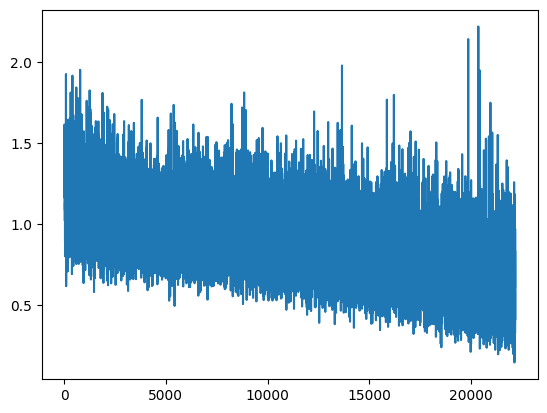

In [38]:
plt.plot(train_losses)

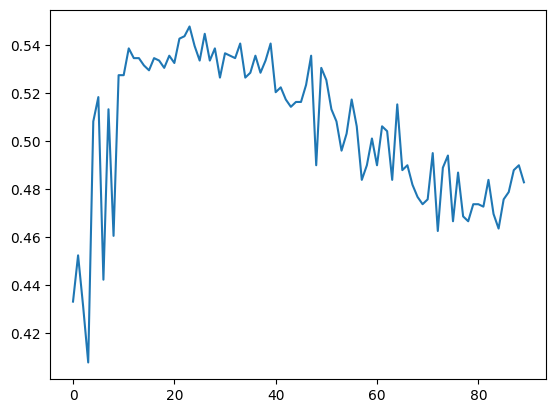

In [39]:
plt.plot(test_accuracy)

In [40]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 455/976 (0.4662)
{'acc_detail': tensor([0.5068, 0.5740, 0.4065, 0.3054], device='cuda:0'),
 'acc_unweighted': tensor(0.4482, device='cuda:0'),
 'acc_weighted': tensor(0.4662, device='cuda:0'),
 'f1s': tensor(0.4544, device='cuda:0'),
 'f1s_detail': tensor([0.4934, 0.5112, 0.4901, 0.3229], device='cuda:0'),
 'precision_detail': tensor([0.4807, 0.4608, 0.6170, 0.3425], device='cuda:0'),
 'recall_detail': tensor([0.5068, 0.5740, 0.4065, 0.3054], device='cuda:0'),
 'rocauc': tensor([0.7647, 0.6582, 0.8296, 0.6807], device='cuda:0'),
 'uar': tensor(0.4482, device='cuda:0'),
 'wap': tensor(0.4750, device='cuda:0')}


tensor([[112,  56,   5,  48],
        [ 51, 194,  41,  52],
        [  6, 102,  87,  19],
        [ 64,  69,   8,  62]], device='cuda:0')

In [41]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_iemocap4/iemocap_label4_m18_best_24epoch.pt
Correct: 541/976 (0.5543)
{'acc_detail': tensor([0.6425, 0.7751, 0.4299, 0.2217], device='cuda:0'),
 'acc_unweighted': tensor(0.5173, device='cuda:0'),
 'acc_weighted': tensor(0.5543, device='cuda:0'),
 'f1s': tensor(0.5172, device='cuda:0'),
 'f1s_detail': tensor([0.6174, 0.6298, 0.5396, 0.2821], device='cuda:0'),
 'precision_detail': tensor([0.5941, 0.5304, 0.7244, 0.3879], device='cuda:0'),
 'recall_detail': tensor([0.6425, 0.7751, 0.4299, 0.2217], device='cuda:0'),
 'rocauc': tensor([0.8362, 0.7383, 0.8588, 0.7149], device='cuda:0'),
 'uar': tensor(0.5173, device='cuda:0'),
 'wap': tensor(0.5577, device='cuda:0')}


tensor([[142,  45,   3,  31],
        [ 20, 262,  27,  29],
        [  6, 105,  92,  11],
        [ 71,  82,   5,  45]], device='cuda:0')

In [42]:
checkpoint_path = '../models_iemocap4/iemocap4_m18_90epoch.ckpt'
torch.save({
    'epoch': 90,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [43]:
# del model, best_model
# gc.collect()

565